In [1]:
setwd("/home/users/astar/gis/stufrancis/scratch/R_work/multiome")

In [3]:
library("Signac")
library("Seurat")
library("tidyverse")
library("data.table")
library("dplyr")
library("R.utils")
library("future")
library("EnsDb.Hsapiens.v86")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::reduce() masks Signac::reduce()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, firs

In [4]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 150)

In [145]:
multiome_prefixes <- c("SRR17909502", "SRR17909503", "SRR17909504", 
                       "SRR17909505", "SRR17909506", "SRR17909507", 
                       "SRR17909508", "SRR17909509", "control_10_retina",
                       "control_10_rpe_choroid", "control_2_rpe_choroid",
                       "control_3_purified_rpe", "control_9_retina", 
                       "control_9_rpe_choroid", "melas_1_purified_rpe",
                       "melas_1_retina", "melas_1_rpe_choroid_rep1",
                       "melas_1_rpe_choroid_rep2")

In [128]:
test_prefixes <- c("SRR17909502")

# dry run for 1 object (can ignore)

In [157]:
##Multiome object control_9_retina
fragpath <- paste0("./frags/", "control_9_retina", "_f.tsv.gz")
counts <- Read10X_h5(paste0("./filtered_matrix/", "control_9_retina", "_filtered_matrix.h5"))
rna_counts <- counts$`Gene Expression`

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [158]:
metadata <- read_csv(file = "./metrics/control_9_retina_metrics.csv", show_col_types = FALSE)
#metadata <- metadata %>% column_to_rownames("barcode")

In [159]:
message(paste("loading_metadata"))

metadata <- dplyr::filter(metadata, is_cell ==1,
               atac_fragments > 1000) %>%
               dplyr::rename(
                    duplicate=atac_dup_reads,
                    chimeric=atac_chimeric_reads,
                    unmapped=atac_unmapped_reads,
                    lowmapq=atac_lowmapq,
                    mitochondrial=atac_mitochondrial_reads,
                    passed_filters=atac_fragments,
                    is__cell_barcode=is_cell,
                    excluded_reason=excluded_reason,
                    TSS_fragments=atac_TSS_fragments,
                    peak_region_fragments=atac_peak_region_fragments,
                    peak_region_cutsites=atac_peak_region_cutsites)%>%
                    column_to_rownames("barcode")

loading_metadata



In [144]:
metadata %>% dim()

[1] 6283   30

In [145]:
rna_counts <- counts$`Gene Expression`

In [ ]:
rna_counts %>% colnames() %>% length()

In [163]:
##this step is needed to filter out the barcodes that do not have a lot of atac peaks
rna_counts <- rna_counts[, colnames(rna_counts) %in% rownames(metadata)]

In [164]:
rna_counts %>% colnames() %>% length()

[1] 6283

In [ ]:
atac_counts <- FeatureMatrix(
                  fragments = fragments,
                  features = commonpeakset_atlas,
                  cells = rownames(metadata)
                )

Extracting reads overlapping genomic regions



In [ ]:
fragments <- CreateFragmentObject(
              path = fragpath,
              cells = rownames(metadata)
                )

In [165]:
message(paste("loading_rna_assay"))

control_9_retina <- CreateSeuratObject(
                      counts = rna_counts,
                      assay = "RNA",
                    project = "control_9_retina"      
                    )

loading_rna_assay



In [77]:
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevels(annotation) <- paste0('chr', seqlevels(annotation))

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [166]:
message(paste("loading_atac_assay"))

control_9_retina[["ATAC"]] <- CreateChromatinAssay(
  counts = atac_counts,
  sep = c(":", "-"),
  fragments = fragpath,
  annotation = annotation,
    min.cells = 10,
  min.features = 200
)

loading_atac_assay

Computing hash



In [167]:
control_9_retina <- AddMetaData(
      object = control_9_retina,
      metadata = metadata
    )

In [170]:
control_9_retina@meta.data %>% head()

orig.ident       nCount_RNA nFeature_RNA nCount_ATAC
AAACAGCCATCCTGAA-1 control_9_retina 2780       1739         3806       
AAACATGCAAGGTCCT-1 control_9_retina 3824       1936         1062       
AAACATGCATAGCTGC-1 control_9_retina 2047       1253         2096       
AAACATGCATTGGGAG-1 control_9_retina 1028        708         4131       
AAACATGCATTGTCAG-1 control_9_retina  101         99          466       
AAACCAACAACAGGAT-1 control_9_retina  523        472          692       
                   nFeature_ATAC gex_barcode        atac_barcode      
AAACAGCCATCCTGAA-1 3380          AAACAGCCATCCTGAA-1 ACAGCGGGTCAGTGAA-1
AAACATGCAAGGTCCT-1  984          AAACATGCAAGGTCCT-1 CATTTAGGTTTGGCTG-1
AAACATGCATAGCTGC-1 1944          AAACATGCATAGCTGC-1 CATTTAGGTCATCATA-1
AAACATGCATTGGGAG-1 3564          AAACATGCATTGGGAG-1 CATTTAGGTGTCCACA-1
AAACATGCATTGTCAG-1  460          AAACATGCATTGTCAG-1 CATTTAGGTTTAATCG-1
AAACCAACAACAGGAT-1  667          AAACCAACAACAGGAT-1 CTTTATCGTAGTTACC-1
                   is__cell_barcode excluded_reason gex_raw_reads ⋯
AAACAGCCATCCTGAA-1 1                0               32790         ⋯
AAACATGCAAGGTCCT-1 1                0               48331         ⋯
AAACATGCATAGCTGC-1 1                0               16911         ⋯
AAACATGCATTGGGAG-1 1                0               15680         ⋯
AAACATGCATTGTCAG-1 1                0                 598         ⋯
AAACCAACAACAGGAT-1 1                0                3226         ⋯
                   atac_raw_reads unmapped lowmapq duplicate chimeric
AAACAGCCATCCTGAA-1 79090          897      5855    62890     22      
AAACATGCAAGGTCCT-1 20058          308      1459    15195     46      
AAACATGCATAGCTGC-1 50738          448      3622    42559     59      
AAACATGCATTGGGAG-1 73722          869      5487    61532     26      
AAACATGCATTGTCAG-1 13815          311      1332    11054     15      
AAACCAACAACAGGAT-1 13993          337      1130    11333      0      
                   mitochondrial passed_filters TSS_fragments
AAACAGCCATCCTGAA-1 3994          5421           2269         
AAACATGCAAGGTCCT-1 1681          1369            756         
AAACATGCATAGCTGC-1  223          3792           1252         
AAACATGCATTGGGAG-1  574          5143           2837         
AAACATGCATTGTCAG-1   76          1027            238         
AAACCAACAACAGGAT-1   68          1117            448         
                   peak_region_fragments peak_region_cutsites
AAACAGCCATCCTGAA-1 3490                  6896                
AAACATGCAAGGTCCT-1 1006                  1997                
AAACATGCATAGCTGC-1 1919                  3774                
AAACATGCATTGGGAG-1 3888                  7709                
AAACATGCATTGTCAG-1  423                   836                
AAACCAACAACAGGAT-1  647                  1277

In [90]:
DefaultAssay(control_9_retina) <- "ATAC"

In [102]:
## probably need to filter the rna count data the rna counts
rownames(control_9_retina[[]]) %>% length()

In [140]:
control_9_retina@meta.data %>% head()

orig.ident       nCount_RNA nFeature_RNA nCount_ATAC
AAACAGCCAATTAAGG-1 control_9_retina  670       515          NA         
AAACAGCCACTGGCTG-1 control_9_retina 1115       549          NA         
AAACAGCCAGGAATCG-1 control_9_retina  199       164          NA         
AAACAGCCAGGGAGGA-1 control_9_retina  337       247          NA         
AAACAGCCAGTAAGTA-1 control_9_retina  327       272          NA         
AAACAGCCATATAACC-1 control_9_retina  937       630          NA         
                   nFeature_ATAC
AAACAGCCAATTAAGG-1 NA           
AAACAGCCACTGGCTG-1 NA           
AAACAGCCAGGAATCG-1 NA           
AAACAGCCAGGGAGGA-1 NA           
AAACAGCCAGTAAGTA-1 NA           
AAACAGCCATATAACC-1 NA

##Multiome object control_9_retina
fragpath <- paste0("./frags/", "control_9_retina", "_f.tsv.gz")
counts <- Read10X_h5(paste0("./filtered_matrix/", "control_9_retina", "_filtered_matrix.h5"))
rna_counts <- counts$`Gene Expression`

metadata <- read_csv(paste0("./metrics/", "control_9_retina", "_metrics.csv"), show_col_types = FALSE)

message(paste("loading_metadata",i))

metadata <- dplyr::filter(metadata, is_cell ==1,
               atac_fragments > 1000)%>%
               dplyr::rename(barcode=atac_barcode,
                    duplicate=atac_dup_reads,
                    chimeric=atac_chimeric_reads,
                    unmapped=atac_unmapped_reads,
                    lowmapq=atac_lowmapq,
                    mitochondrial=atac_mitochondrial_reads,
                    passed_filters=atac_fragments,
                    is_cell_barcode=is_cell,
                    excluded_reason=excluded_reason,
                    TSS_fragments=atac_TSS_fragments,
                    peak_region_fragments=atac_peak_region_fragments,
                    peak_region_cutsites=atac_peak_region_cutsites) %>%
            column_to_rownames("barcode")

message(paste("loading_fragments",i))

fragments <- CreateFragmentObject(
              path = fragpath,
              cells = rownames(metadata)
                )

atac_counts <- FeatureMatrix(
                  fragments = fragments,
                  features = commonpeakset,
                  cells = rownames(metadata)
                )

message(paste("loading_rna_assay",i))

control_9_retina <- CreateSeuratObject(
                      counts = rna_counts,
                      assay = "RNA",
                      project="Something"
                    )


message(paste("loading_atac_assay",i))

control_9_retina[["ATAC"]] <- CreateChromatinAssay(
  counts = atac_counts,
  sep = c(":", "-"),
  fragments = fragpath,
  annotation = annotation
    
)

control_9_retina <- AddMetaData(
      object = control_9_retina,
      metadata = metadata
    )

In [290]:
control_9_retina

An object of class Seurat 
469704 features across 14212 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC

In [57]:
ls()

[1] "atac_merger"         "atac_object"         "atac_prefixes"      
 [4] "commonpeakset_atlas" "CommonPeakSetter"    "counts"             
 [7] "fragpath"            "GSE196235"           "GSE196235_prefixes" 
[10] "MergePeaks_better"   "metadata"            "multiome_object"    
[13] "retina_atlas"        "rna_counts"          "run_merge_atac"     
[16] "sample_prefixes"     "SRR13633765"         "SRR13633773"        
[19] "SRR23990991"         "SRR23990998"

# CommonPeakSet

https://stuartlab.org/signac/articles/merging

In [14]:
# Code to create a CommonPeakSet

CommonPeakSetter <- function(dataset_prefixes) {
    result_bed <- list()
    result_gr <- list()
    
    message('--Bed files--')
    for (i in dataset_prefixes){
        message(paste("loading",i))
        result_bed[[i]] <-  read.table(file = paste0("./bed/",i,"_peaks.bed"),
               col.names = c("chr", "start", "end"))

        result_gr[[i]] <- makeGRangesFromDataFrame(result_bed[[i]]) 
        }
    
    message('--Combine--')
    combined.peaks <- Signac::reduce(x = Reduce(c, result_gr))

    peakwidths <- width(combined.peaks)
    combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]

    return(combined.peaks)
}

In [12]:
mini_atlas_peak_prefixes <- c("SRR13633773", "SRR13633765","SRR23990991", "SRR23990998",
                              "control_9_retina","melas_1_retina","SRR17909502", "SRR17909509")

In [15]:
# This was generated from the peaks of GSE196235 and multiome portion of GSE202747
commonpeakset_atlas <- CommonPeakSetter(mini_atlas_peak_prefixes)

--Bed files--

loading SRR13633773

loading SRR13633765

loading SRR23990991

loading SRR23990998

loading control_9_retina

loading melas_1_retina

loading SRR17909502

loading SRR17909509

--Combine--

Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': KI270727.1, KI270726.1
  - in 'y': GL000009.2
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."


# Loop to create multiome objects per sample

In [10]:
multiome_merger <-function(multiome_prefixes, common_peak_set){
    annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
    seqlevels(annotation) <- paste0('chr', seqlevels(annotation))

    for (id in multiome_prefixes){
        fragpath <- paste0("./frags/", id, "_f.tsv.gz")
        counts <- Read10X_h5(paste0("./filtered_matrix/", id, "_filtered_matrix.h5"))

        message(paste("loading_counts"))
        rna_counts <- counts$`Gene Expression`
        
        metadata <- read_csv(paste0("./metrics/", id, "_metrics.csv"), show_col_types = FALSE)
        #metadata <- metadata %>% column_to_rownames("barcode")
        
        message(paste("loading_metadata"))
        
        metadata <- dplyr::filter(metadata, is_cell ==1,
                       atac_fragments > 1000) %>%
                       dplyr::rename(
                            duplicate=atac_dup_reads,
                            chimeric=atac_chimeric_reads,
                            unmapped=atac_unmapped_reads,
                            lowmapq=atac_lowmapq,
                            mitochondrial=atac_mitochondrial_reads,
                            passed_filters=atac_fragments,
                            is__cell_barcode=is_cell,
                            excluded_reason=excluded_reason,
                            TSS_fragments=atac_TSS_fragments,
                            peak_region_fragments=atac_peak_region_fragments,
                            peak_region_cutsites=atac_peak_region_cutsites)%>%
                            column_to_rownames("barcode")

        message(paste("removing low peak count cells from rna counts"))
        rna_counts <- rna_counts[, colnames(rna_counts) %in% rownames(metadata)]
        
        message(paste("loading_fragments"))
        
        fragments <- CreateFragmentObject(
                      path = fragpath,
                      cells = rownames(metadata)
                        )


        message(paste("atac_counts"))
        
        atac_counts <- FeatureMatrix(
                          fragments = fragments,
                          features = common_peak_set,
                          cells = rownames(metadata)
                        )
        
        message(paste("seurat_object"))
        
        tmp <- CreateSeuratObject(
                              counts = rna_counts,
                              assay = "RNA",
                              project = id
                            )
        
        message(paste("loading_atac_assay"))
        
        tmp[["ATAC"]] <- CreateChromatinAssay(
          counts = atac_counts,
          sep = c(":", "-"),
          fragments = fragpath,
          annotation = annotation
        )
        
        tmp <- AddMetaData(
              object = tmp,
              metadata = metadata
            )
        assign(id, tmp, envir = .GlobalEnv)
        }

    return('done')
    }

In [8]:
multiome_prefixes <- c("control_9_retina","melas_1_retina","SRR17909502", "SRR17909509")

In [ ]:
run_multiome_script <- multiome_merger(multiome_prefixes, common_peak_set = commonpeakset_atlas)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [21]:
ls()

[1] "commonpeakset_atlas"      "CommonPeakSetter"        
 [3] "control_9_retina"         "GSE196235"               
 [5] "GSE196235_prefixes"       "melas_1_retina"          
 [7] "MergePeaks_better"        "mini_atlas_peak_prefixes"
 [9] "multiome_merger"          "multiome_prefixes"       
[11] "run_multiome_script"      "SRR17909502"             
[13] "SRR17909509"

## QC each dataset individually

Skipped for now

## Run LSI for each sample object for batch correction later on

In [24]:
# For loop to calculate TFIDF for each sample object
for (prefix in multiome_prefixes){
    data <- get(prefix)

    DefaultAssay(data) <- "ATAC"
    data <- FindTopFeatures(data, min.cutoff = 10)
    data <- RunTFIDF(data)
    data <- RunSVD(data)
    
    data$dataset <- prefix
    
    data <- RunUMAP(object = data, reduction = 'lsi', dims = 2:30)
    data <- FindNeighbors(object = data, reduction = 'lsi', dims = 2:30)
        
    assign(prefix, data, envir = .GlobalEnv)

    }

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
16:00:04 UMAP embedding parameters a = 0.9922 b = 1.112

16:00:04 Read 6283 rows and found 29 numeric columns

16:00:04 Using Annoy for neighbor search, n_neighbors = 30

16:00:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:00:04 Writing NN index file to temp file /tmp/RtmpjCLklQ/

In [27]:
ls()

[1] "commonpeakset_atlas"      "CommonPeakSetter"        
 [3] "control_9_retina"         "data"                    
 [5] "GSE196235"                "GSE196235_prefixes"      
 [7] "melas_1_retina"           "MergePeaks_better"       
 [9] "mini_atlas_peak_prefixes" "multiome_merger"         
[11] "multiome_prefixes"        "prefix"                  
[13] "run_multiome_script"      "SRR17909502"             
[15] "SRR17909509"

In [ ]:
multiome_object <- merge(
  x = control_9_retina,
  y = list(SRR17909502,SRR17909509,melas_1_retina),
  add.cell.ids = c("control_9_retina", "SRR17909502", "SRR17909509", "melas_1_retina")
)

In [ ]:
# process the combined dataset
multiome_object <- FindTopFeatures(multiome_object, min.cutoff = 10)
multiome_object <- RunTFIDF(multiome_object)
multiome_object <- RunSVD(multiome_object)
multiome_object <- RunUMAP(multiome_object, reduction = "lsi", dims = 2:30)
p1 <- DimPlot(multiome_object, group.by = "dataset")

In [ ]:
# find integration anchors
integration.anchors <- FindIntegrationAnchors(
  object.list = list(SRR17909509, SRR17909502, melas_1_retina, control_9_retina),
  anchor.features = rownames(multiome_object),
  reduction = "rlsi",
  dims = 2:30
)

# integrate LSI embeddings
integrated <- IntegrateEmbeddings(
  anchorset = integration.anchors,
  reductions = multiome_object[["lsi"]],
  new.reduction.name = "integrated_lsi",
  dims.to.integrate = 1:30
)

# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:30)
p2 <- DimPlot(integrated, group.by = "dataset")

In [6]:
ls()

[1] "commonpeakset"      "GSE196235"          "GSE196235_prefixes"
[4] "MergePeaks_better"

In [184]:
control_9_retina

An object of class Seurat 
469704 features across 6283 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC

# Loop to create ATAC object per sample

In [307]:
##Dry run for singular ATAC object SRR13633765

counts <- Read10X_h5(filename = "../retina_atac/filtered_matrix/SRR13633765_filtered_matrix.h5")
metadata <- read.csv(
  file = "../retina_atac/metrics/SRR13633765_metrics.csv",
  header = TRUE,
) %>% dplyr::filter(barcode != "NO_BARCODE", 
             is__cell_barcode ==1, 
             passed_filters > 1000) %>%
      column_to_rownames("barcode")  



chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  fragments = '../retina_atac/frags/SRR13633765_f.tsv.gz',
  min.cells = 10,
  min.features = 200
)

SRR13633765 <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata,
  project = "SRR13633765"
        
)

Computing hash



In [8]:
atac_merger <- function(atac_prefixes, common_peak_set){
    annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
    seqlevels(annotation) <- paste0('chr', seqlevels(annotation))
    for (id in atac_prefixes){
        counts <- Read10X_h5(paste0("../retina_atac/filtered_matrix/", id, "_filtered_matrix.h5"))
        fragpath <- paste0("../retina_atac/frags/", id, "_f.tsv.gz")

        
        

        message(paste("loading_metadata"))

        metadata <- read.csv(
          file = paste0("../retina_atac/metrics/", id, "_metrics.csv"),
          header = TRUE,
        ) %>% dplyr::filter(barcode != "NO_BARCODE", 
                     is__cell_barcode == 1, 
                     passed_filters > 1000) %>%
              column_to_rownames("barcode") 

        message(paste("loading_fragments"))
        
        fragments <- CreateFragmentObject(
                  path = fragpath,
                  cells = rownames(metadata)
                    )


        message(paste("atac_counts"))
        
        atac_counts <- FeatureMatrix(
                              fragments = fragments,
                              features = common_peak_set,
                              cells = rownames(metadata)
                            )
        message(paste("chromatin_assay"))
        chrom_assay <- CreateChromatinAssay(
          counts = atac_counts,
          sep = c(":", "-"),
          fragments = fragments,
          min.cells = 10,
          min.features = 200
        )

        message(paste("seurat_object"))
        tmp <- CreateSeuratObject(
          counts = chrom_assay,
          assay = "ATAC",
          meta.data = metadata,
          project = id      
        )

        assign(id, tmp, envir = .GlobalEnv)
        }
    
    return('done')
    }

In [7]:
atac_prefixes <- c("SRR13633773", "SRR13633765","SRR23990991", "SRR23990998")

In [9]:
run_merge_atac <- atac_merger(atac_prefixes, commonpeakset_atlas)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

# Merging into 1 retina_atlas

Please refer to https://stuartlab.org/signac/articles/merging

In [10]:
atac_object <- merge(
    x = SRR13633773, 
    y = list(SRR13633765,SRR23990991, SRR23990998),
    add.cell.ids =  c("SRR13633773", "SRR13633765","SRR23990991", "SRR23990998")
    )

In [186]:
multiome_object <- merge(
  x = control_9_retina,
  y = list(SRR17909502,SRR17909509,melas_1_retina),
  add.cell.ids = c("control_9_retina", "SRR17909502", "SRR17909509", "melas_1_retina")
)

In [188]:
SRR17909502

An object of class Seurat 
469704 features across 5782 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC

In [189]:
SRR17909509

An object of class Seurat 
469704 features across 11349 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC

In [190]:
control_9_retina

An object of class Seurat 
469704 features across 6283 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC

In [191]:
melas_1_retina

An object of class Seurat 
469704 features across 13785 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC

In [198]:
multiome_object

An object of class Seurat 
469704 features across 37199 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 4 layers present: counts.control_9_retina, counts.SRR17909502, counts.SRR17909509, counts.melas_1_retina
 1 other assay present: ATAC

In [200]:
atac_object

An object of class Seurat 
424108 features across 20823 samples within 1 assay 
Active assay: ATAC (424108 features, 0 variable features)
 2 layers present: counts, data

In [18]:
atac_object[["ATAC"]] <- atac_object[["peaks"]]

Warning message:
"Key 'peaks_' taken, using 'atac_' instead"


In [21]:
DefaultAssay(atac_object) <- "ATAC"

In [22]:
atac_object[["peaks"]] <- NULL

In [23]:
atac_object

An object of class Seurat 
424108 features across 20823 samples within 1 assay 
Active assay: ATAC (424108 features, 0 variable features)
 2 layers present: counts, data

In [346]:
multiome_object

An object of class Seurat 
469704 features across 48301 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 4 layers present: counts.SeuratProject, counts.SRR17909502, counts.SRR17909509, counts.melas_1_retina
 1 other assay present: ATAC

In [202]:
saveRDS(multiome_object, "multiome_object.rds")
saveRDS(atac_object, "atac_object.rds")

In [203]:
retina_atlas <- merge(
        x = multiome_object, 
        y = atac_object,
     add.cell.ids = c("multiome_object", "atac_object"))

In [211]:
retina_atlas

An object of class Seurat 
469704 features across 58022 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 4 layers present: counts.control_9_retina, counts.SRR17909502, counts.SRR17909509, counts.melas_1_retina
 1 other assay present: ATAC

In [218]:
retina_atlas@meta.data$orig.ident %>% table()

.
control_9_retina   melas_1_retina      SRR13633765      SRR13633773 
            6283            13785             2077             9347 
     SRR17909502      SRR17909509      SRR23990991      SRR23990998 
            5782            11349             4372             5027 

# QC general guide

In [226]:
multiome_object

An object of class Seurat 
469704 features across 37199 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 4 layers present: counts.control_9_retina, counts.SRR17909502, counts.SRR17909509, counts.melas_1_retina
 1 other assay present: ATAC

In [228]:
multiome_object[["percent.mt"]] <- PercentageFeatureSet(multiome_object, pattern = "^MT-")

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


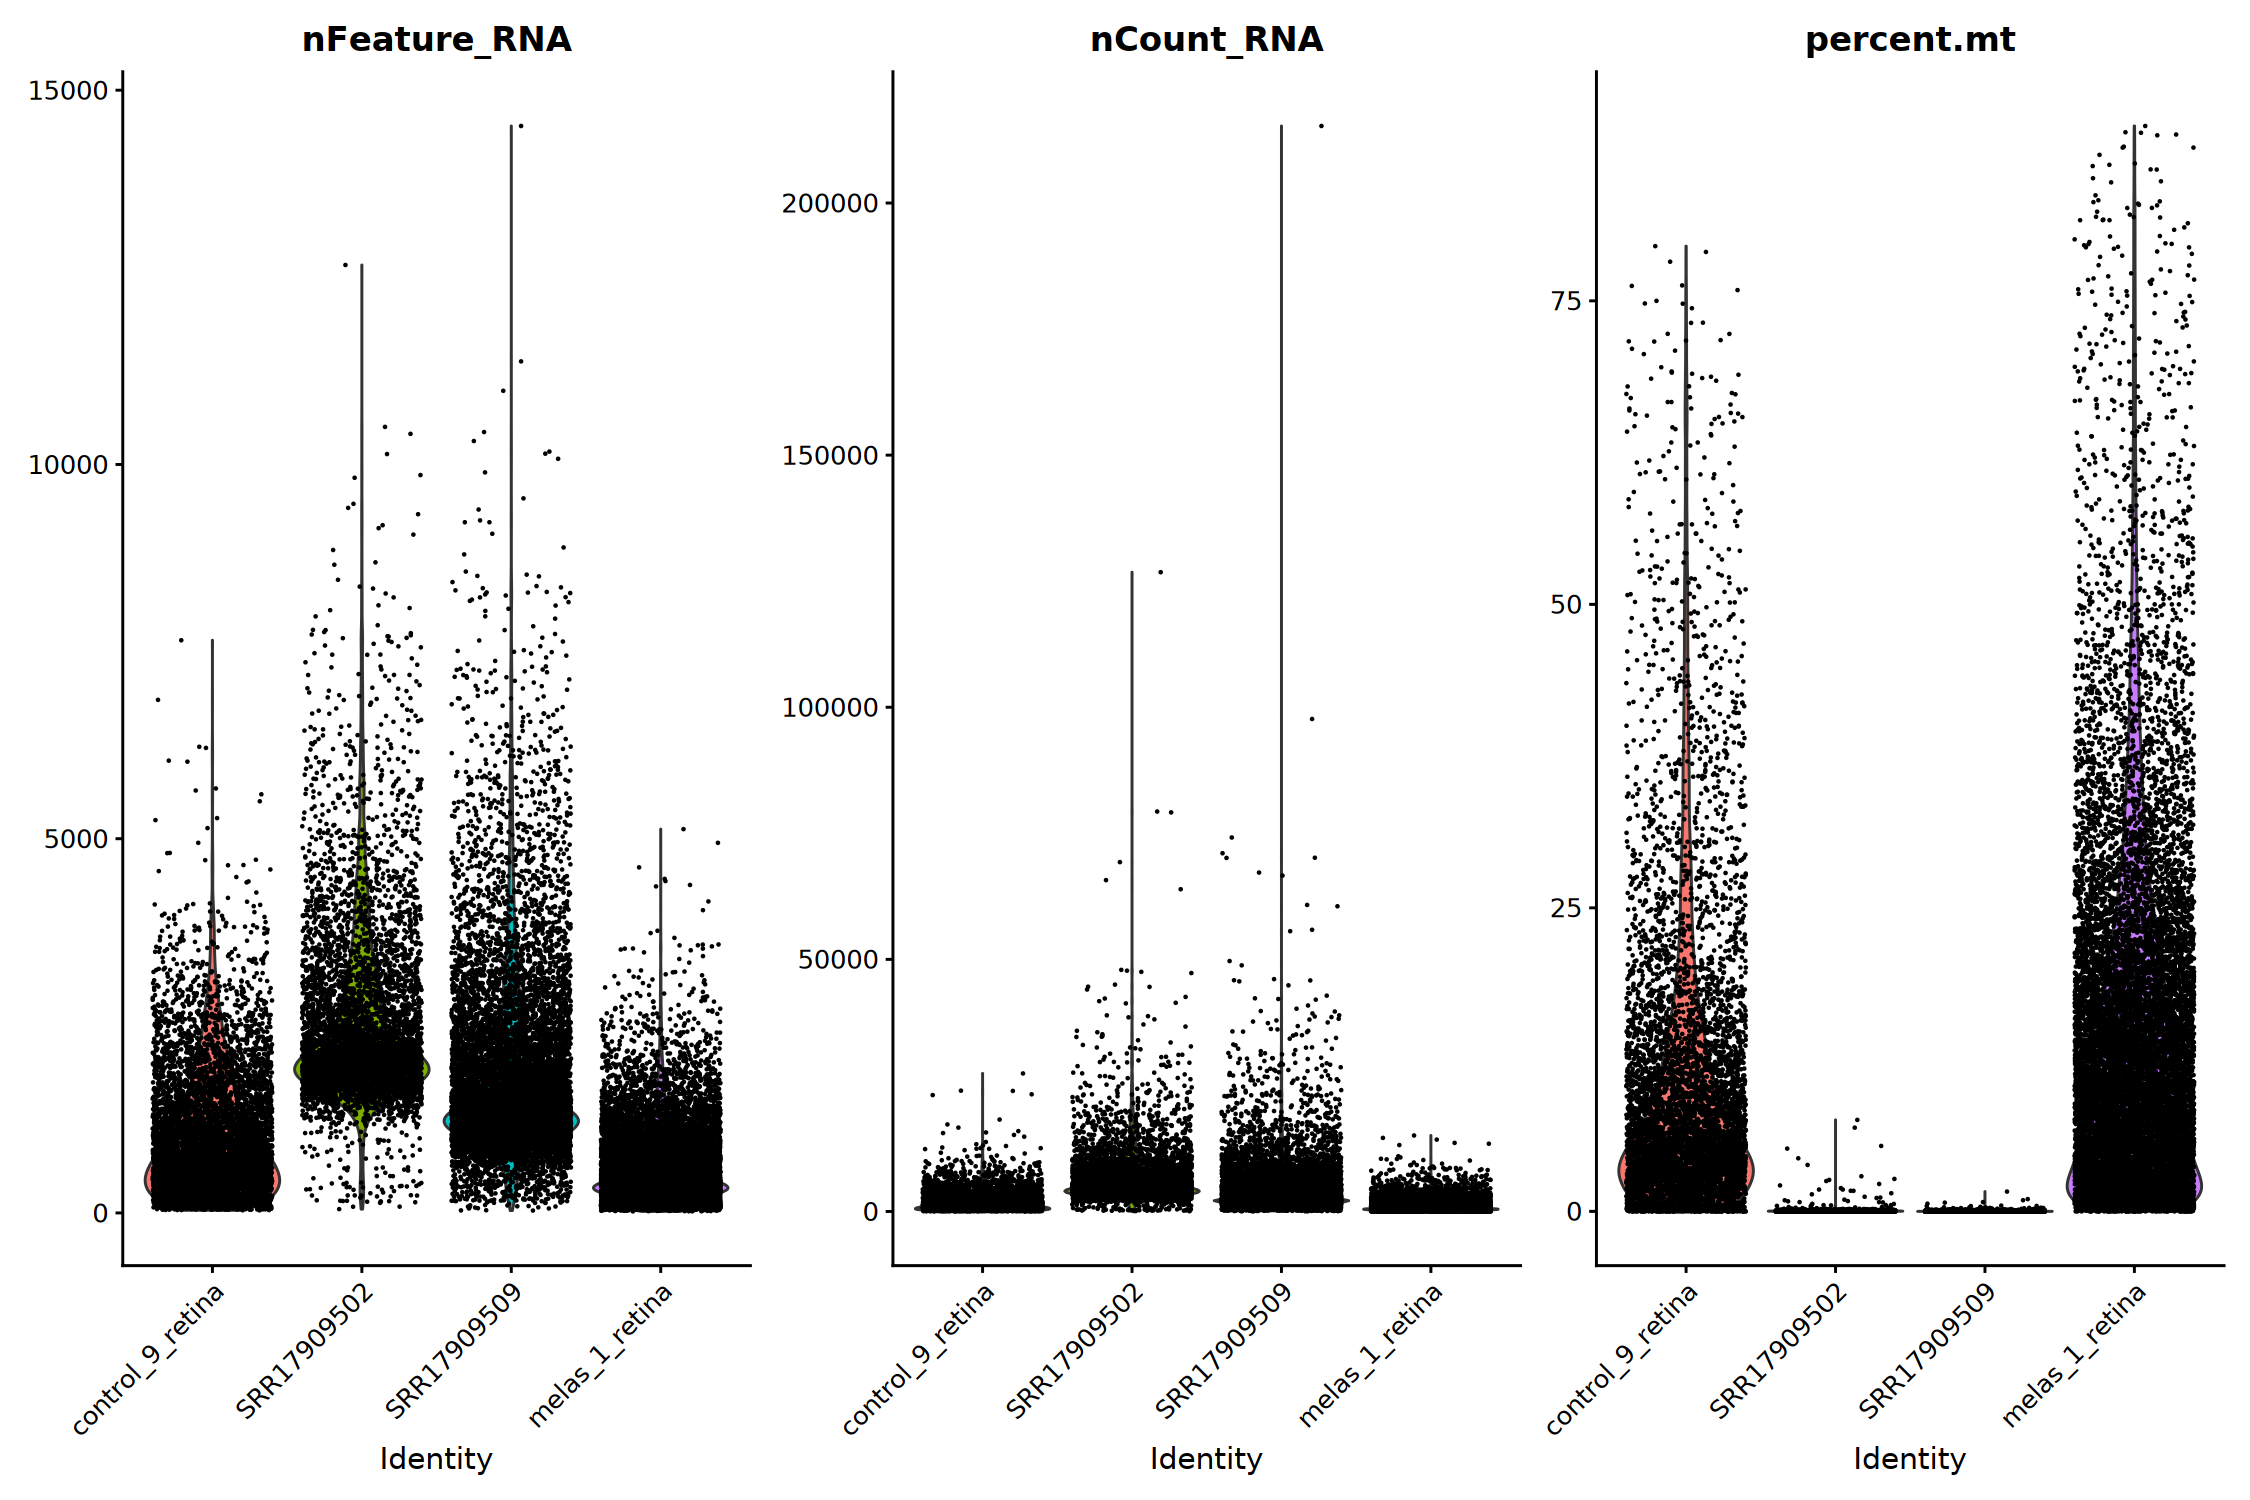

In [234]:
VlnPlot(multiome_object, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [230]:
plot1 <- FeatureScatter(multiome_object, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(multiome_object, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

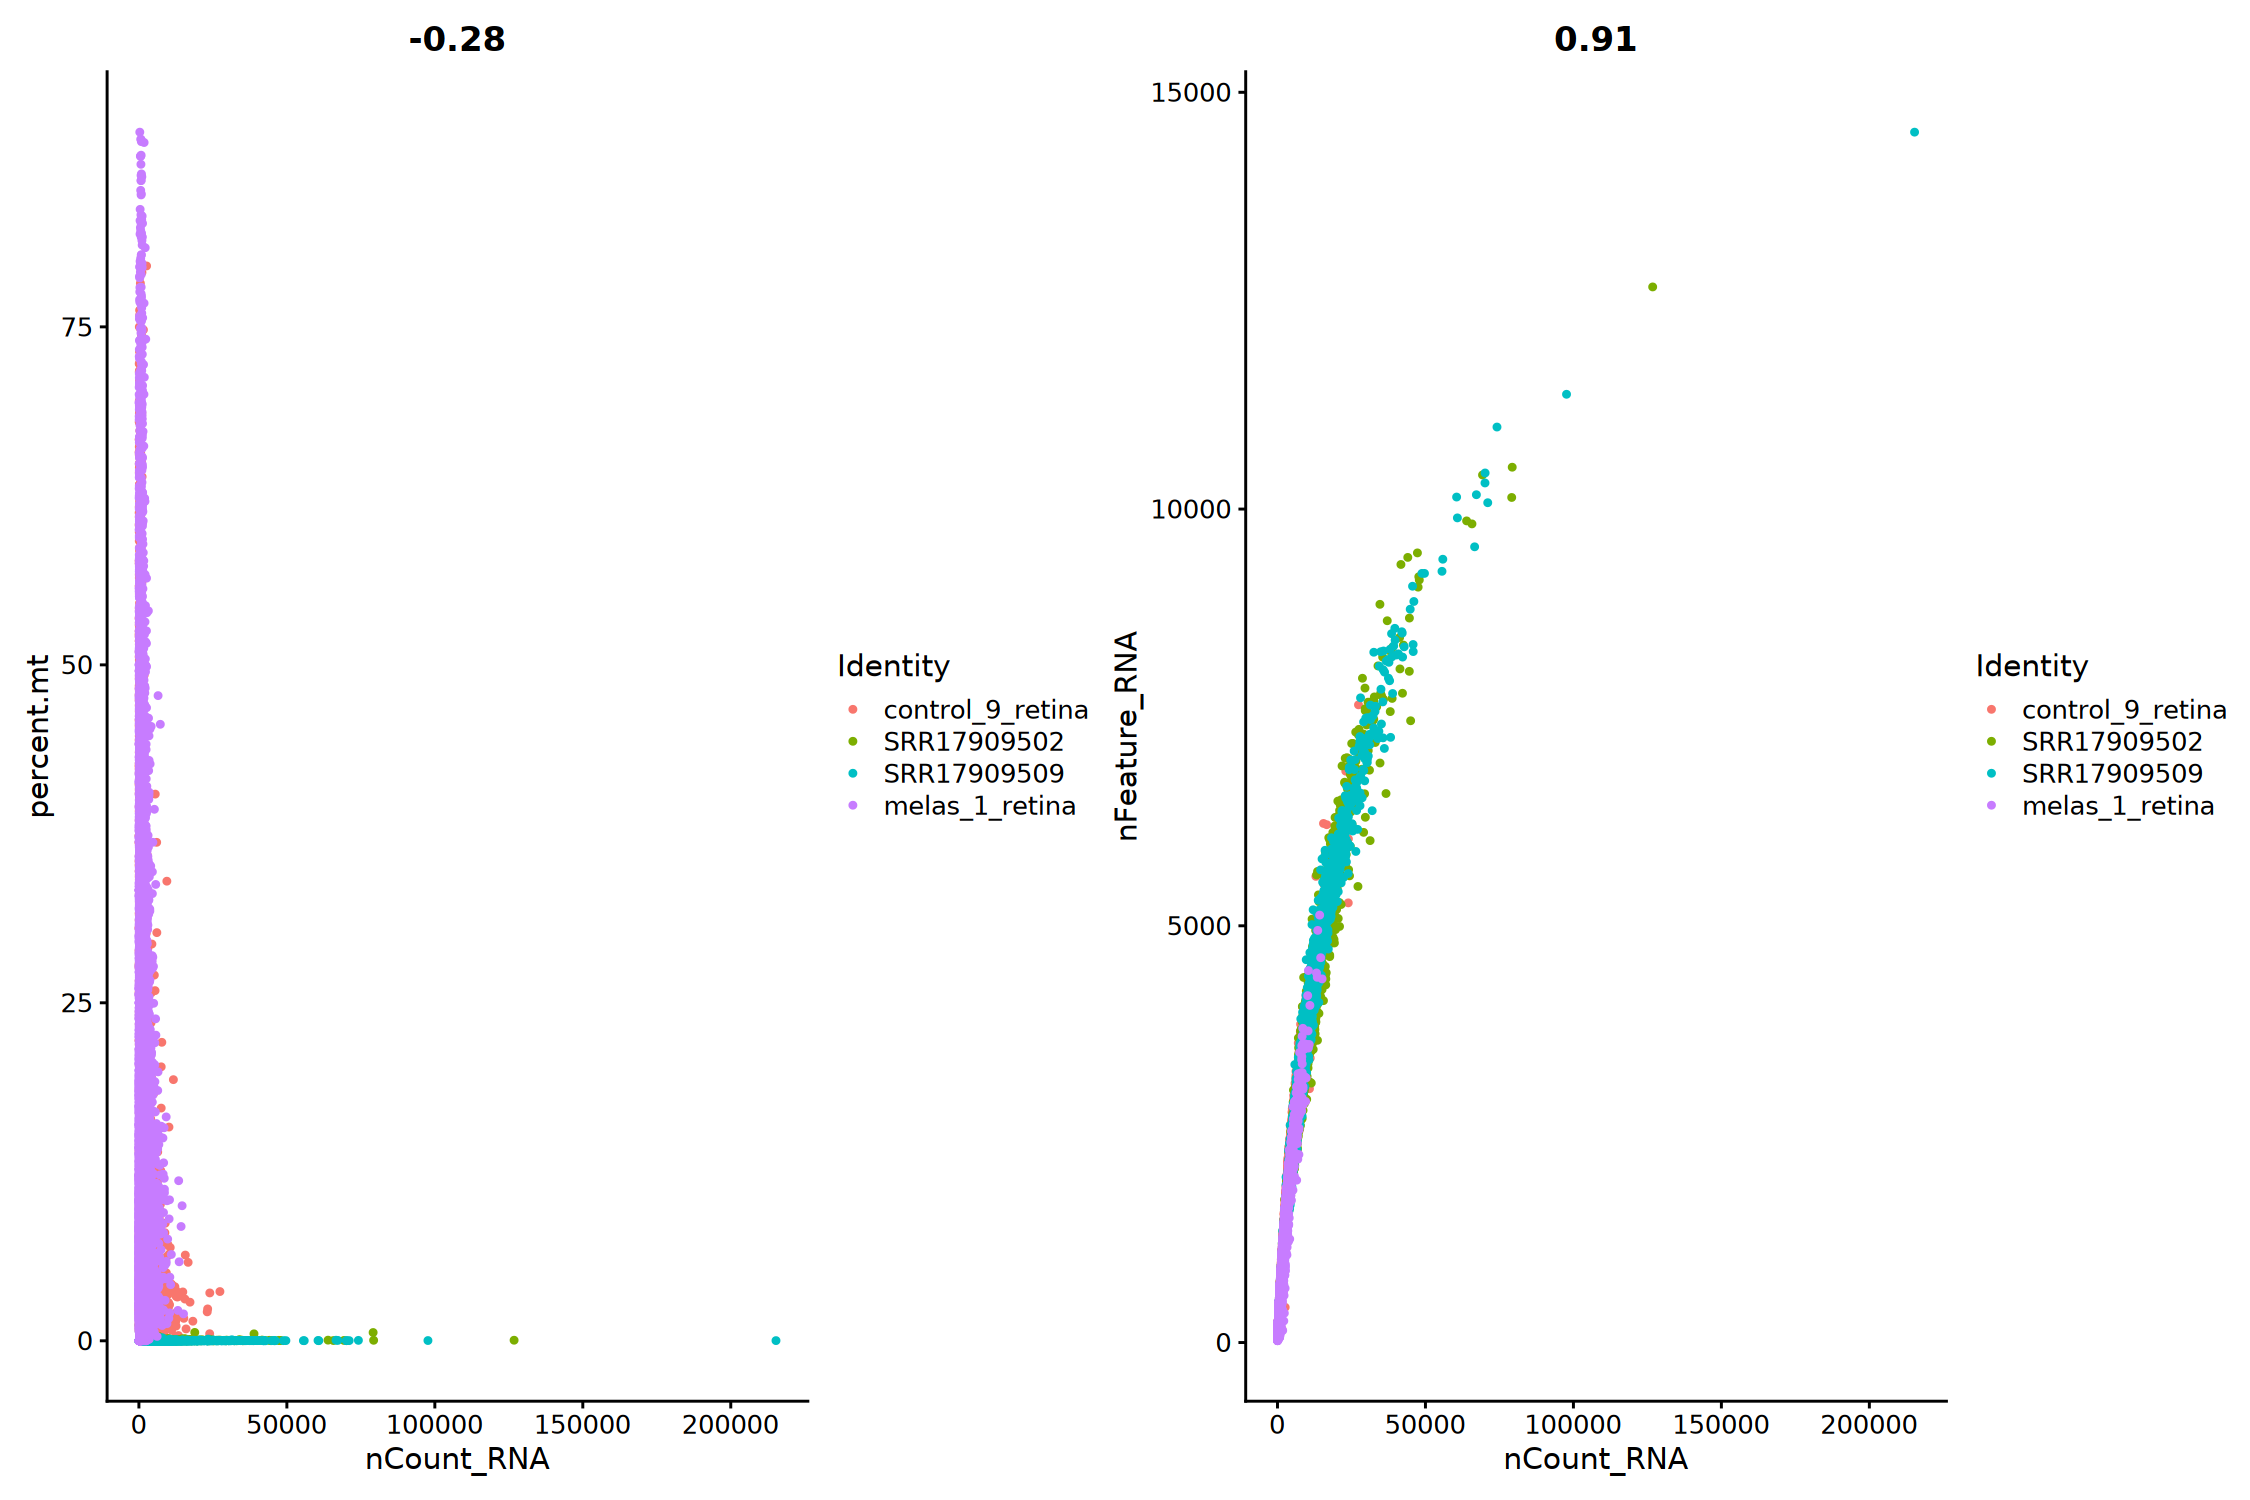

In [233]:
plot1+plot2

In [236]:
multiome_object_QCed <- subset(multiome_object, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 5)

**Multiome object after QC**

In [237]:
multiome_object_QCed

An object of class Seurat 
469704 features across 22034 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 4 layers present: counts.control_9_retina, counts.SRR17909502, counts.SRR17909509, counts.melas_1_retina
 1 other assay present: ATAC

In [240]:
DefaultAssay(multiome_object_QCed) <- "ATAC"

In [375]:
multiome_object_QCed

An object of class Seurat 
469704 features across 22034 samples within 2 assays 
Active assay: ATAC (433103 features, 433103 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 5 dimensional reductions calculated: lsi, umap, pca, umap.unintegrated, integrated.cca

In [373]:
DefaultAssay(multiome_object_QCed) <- "ATAC"

To QC for ATAC, please refer to https://stuartlab.org/signac/articles/pbmc_vignette

# Batch correction for RNA_seq assay of the mutliome object

Please refer to https://satijalab.org/seurat/articles/integration_introduction.html

In [377]:
# run standard anlaysis workflow
multiome_object_QCed <- NormalizeData(multiome_object_QCed)
multiome_object_QCed <- FindVariableFeatures(multiome_object_QCed)
multiome_object_QCed <- ScaleData(multiome_object_QCed)
multiome_object_QCed <- RunPCA(multiome_object_QCed)
multiome_object_QCed <- FindNeighbors(multiome_object_QCed, dims = 1:30, reduction = "pca")
multiome_object_QCed <- FindClusters(multiome_object_QCed, resolution = 2, cluster.name = "unintegrated_clusters")

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  chr19-54419855-54421597, chr1-997726-1001056, chr17-39230824-39232767, chr8-144500275-144504606, chr10-28897416-28898461, chr11-126082136-126083131, chr1-47577867-47579458, chr8-37814641-37815935, chr2-12168767-12170319, chr2-232519456-232520487 
	   chr11-116113964-116115173, chr11-69156990-69157958, chr5-151028540-151030789, chr17-80958690-80960267, chr6-36997511-36999815, chr16-990409-992751, chr16-987096-988918, chr3-197394439-197395690, chr22-24588034-24589213, chr5-178428118-178430207 
	   chr9-36818185-36819631, chr11-12008025-12009797, chr4-7341904-7343466, chr2-2769347-2770347, chr17-72342252-72343549, chr20-58017136-58018243, chr17-68234920-68236004, chr3-188051908-188052910, chr1-182128485-182130599, chr1-22782127-22783160 
Negative:  chr7-129779266-129782532, chrX-2463614-2465429, chr2-20305072-20305986, chr18-57397733-57398884, chr16-46390090-46390983

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22034
Number of edges: 1384863

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2178
Number of communities: 969
Elapsed time: 3 seconds


941 singletons identified. 28 final clusters.



14:58:50 UMAP embedding parameters a = 0.9922 b = 1.112

14:58:50 Read 22034 rows and found 30 numeric columns

14:58:50 Using Annoy for neighbor search, n_neighbors = 30

14:58:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:58:53 Writing NN index file to temp file /tmp/Rtmp9lus3I/filec61b04de3b911

14:58:54 Searching Annoy index using 1 thread, search_k = 3000

14:58:59 Annoy recall = 94.71%

14:59:00 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:59:01 980 smooth knn distance failures

14:59:03 Initializing from normalized Laplacian + noise (using RSpectra)

14:59:03 Commencing optimization for 200 epochs, with 1065034 positive edges

14:59:16 Optimization finished

Warning message:
"The following requested variable

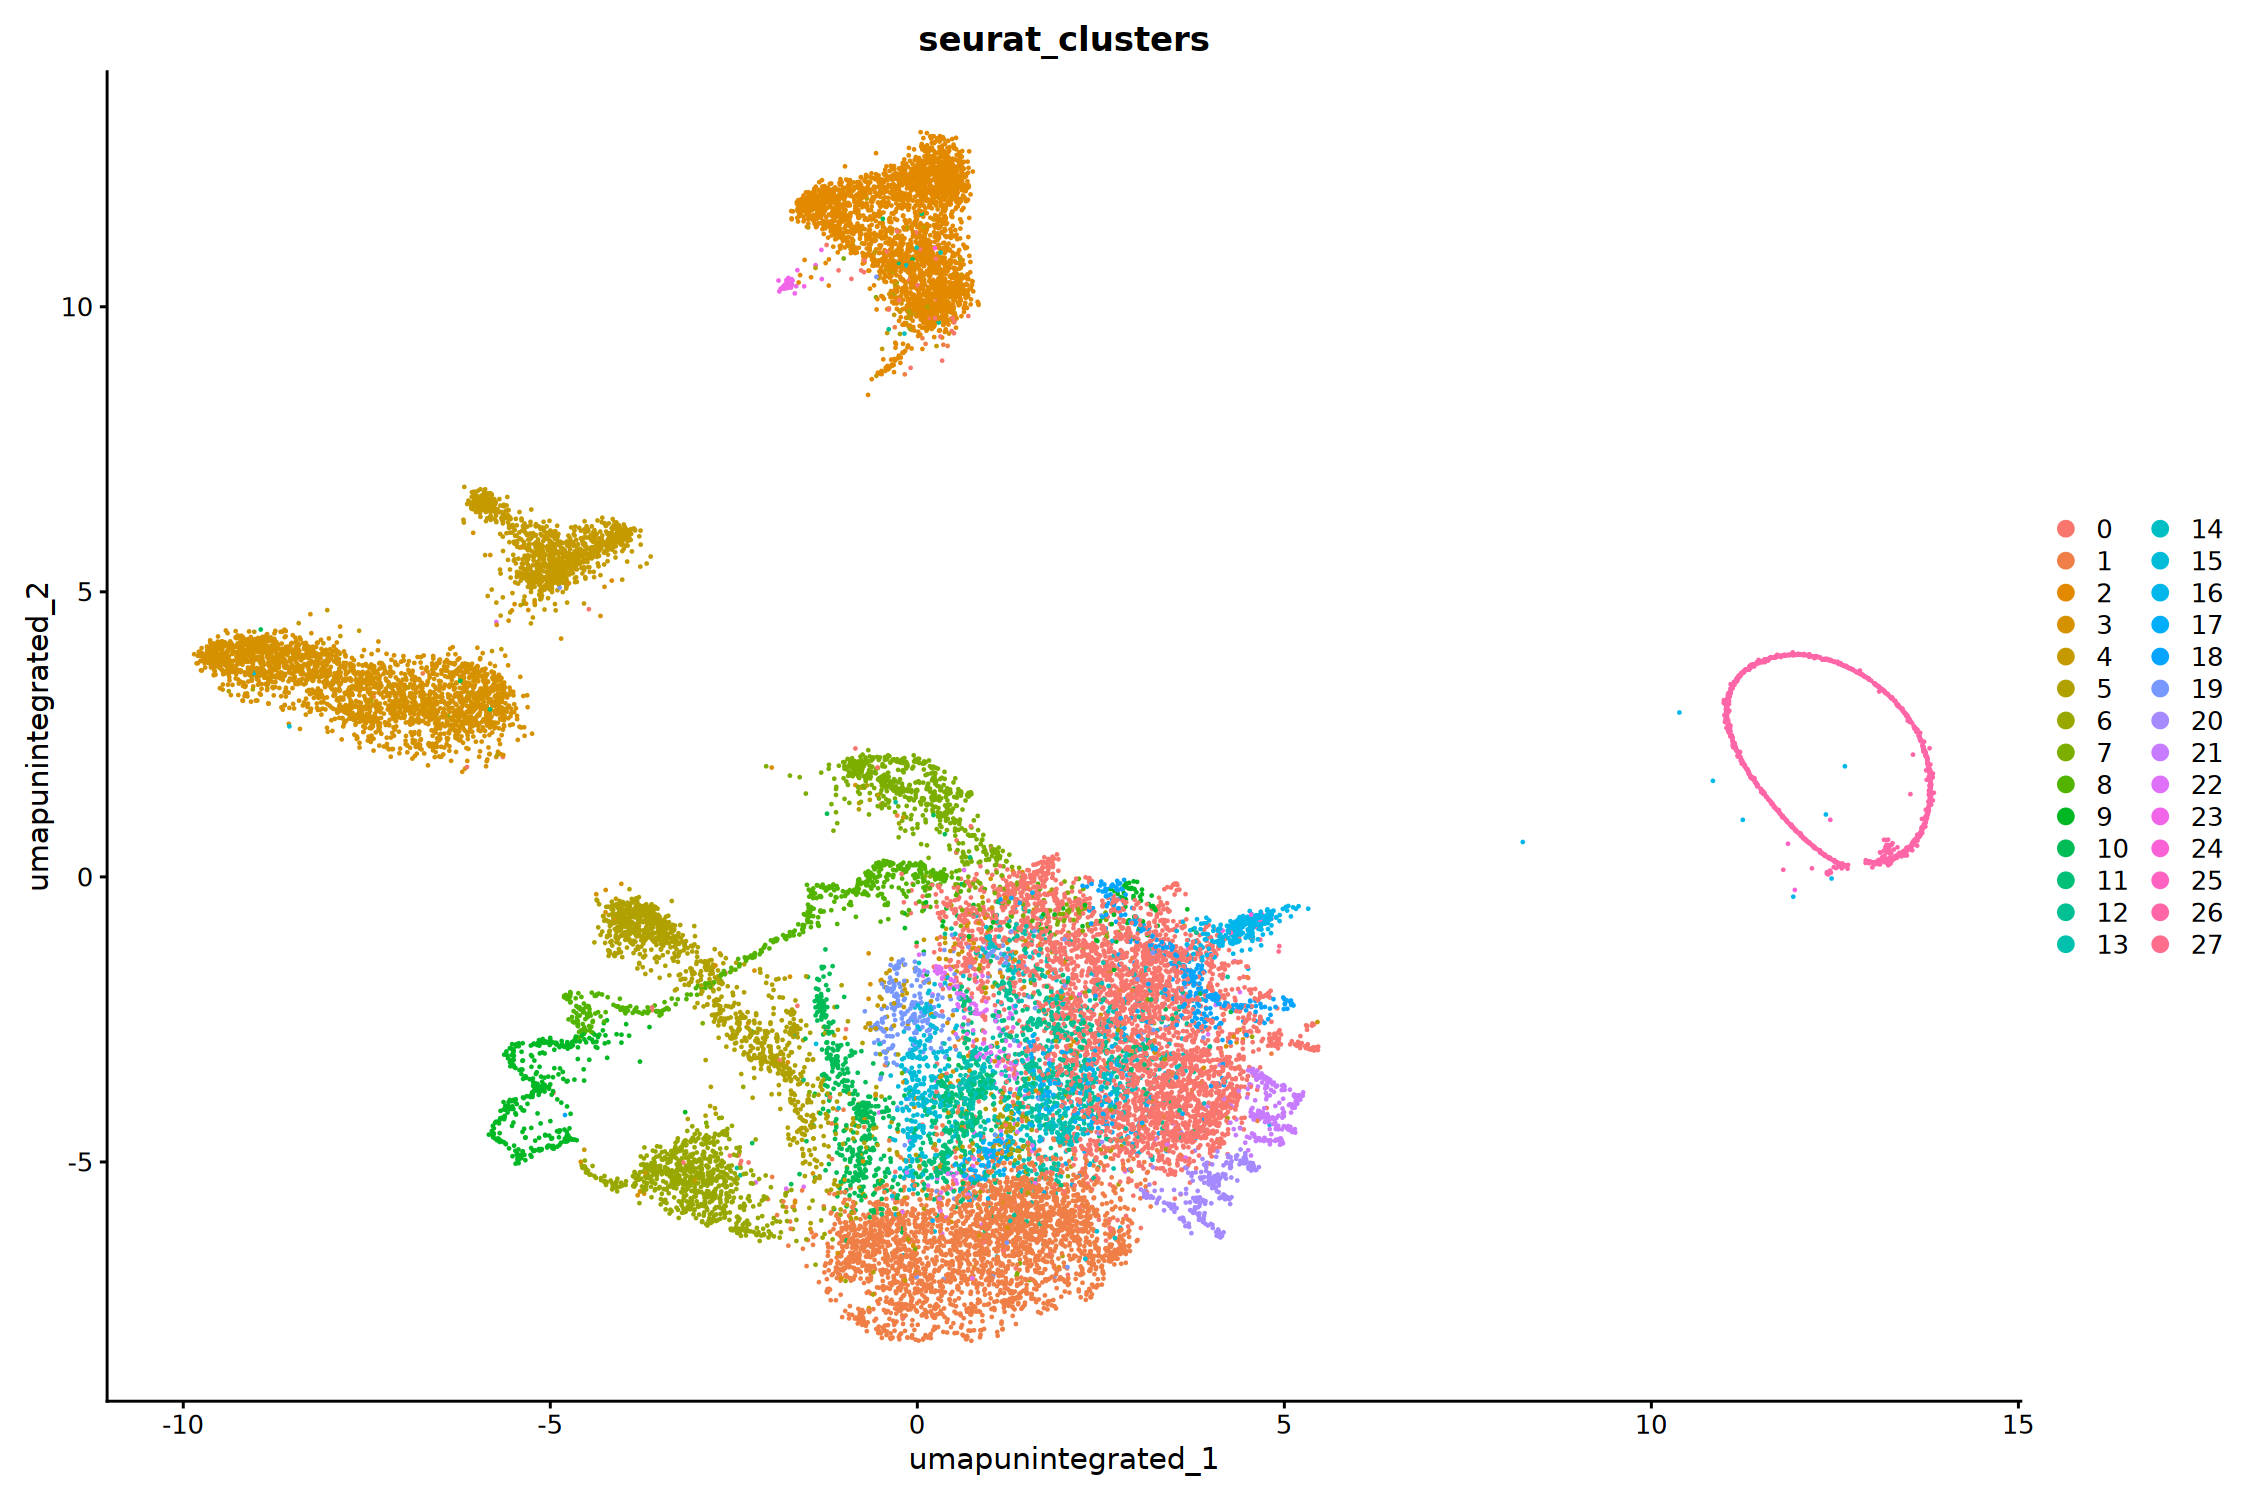

In [378]:
multiome_object_QCed <- RunUMAP(multiome_object_QCed, dims = 1:30, reduction = "pca", reduction.name = "umap.unintegrated")
DimPlot(multiome_object_QCed, reduction = "umap.unintegrated", group.by = c("stim", "seurat_clusters"))

In [379]:
multiome_object_QCed <- IntegrateLayers(object = multiome_object_QCed, method = CCAIntegration, orig.reduction = "pca", new.reduction = "integrated.cca",
    verbose = FALSE)

ERROR: Error in UseMethod(generic = "Assays", object = object): no applicable method for 'Assays' applied to an object of class "NULL"


In [365]:
DefaultAssay(multiome_object_QCed) <- "RNA" 

In [364]:
multiome_object_QCed

An object of class Seurat 
469704 features across 22034 samples within 2 assays 
Active assay: ATAC (433103 features, 433103 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

In [362]:
multiome_object_QCed[["RNA"]] <- as(object = multiome_object_QCed[["RNA"]], Class = "Assay5")

In [366]:
# run standard anlaysis workflow
multiome_object_QCed <- NormalizeData(multiome_object_QCed)
multiome_object_QCed <- FindVariableFeatures(multiome_object_QCed)
multiome_object_QCed <- ScaleData(multiome_object_QCed)
multiome_object_QCed <- RunPCA(multiome_object_QCed)

Normalizing layer: counts.control_9_retina

Normalizing layer: counts.SRR17909502

Normalizing layer: counts.SRR17909509

Normalizing layer: counts.melas_1_retina

Finding variable features for layer counts.control_9_retina

Finding variable features for layer counts.SRR17909502

Finding variable features for layer counts.SRR17909509

Finding variable features for layer counts.melas_1_retina

Centering and scaling data matrix

PC_ 1 
Positive:  GPM6A, CTNNA2, LSAMP, ADGRL3, NAV3, DACH1, GRIA4, AC092691.1, TRPM3, MIR99AHG 
	   KIAA1217, NRXN3, NEAT1, NAV2, DTNA, NRG3, KAZN, PCDH9, GABRG3, DCLK1 
	   FRMD4A, SLC35F1, TANC1, SPOCK1, GRID2, NCKAP5, NKAIN2, FYN, APP, PRKG1 
Negative:  OTX2-AS1, FSTL5, MEIS2, CDH12, EPHA3, PRELID2, DLGAP2, MIR646HG, VWC2, LINC00871 
	   RGS20, ZFPM2-AS1, GUCA1C, CFAP299, AP000676.5, SNTG2, UNC13C, ANO3, CCDC39, DOCK8 
	   MPP6, TNFAIP3, GBE1, RHOBTB1, AL357172.1, LRP2, ESRRG, POU2AF1, LINC02296, VAV3 
PC_ 2 
Positive:  MDGA2, CADPS, DGKI, EDIL3, DOK6, RYR2, 

In [367]:
multiome_object_QCed <- FindNeighbors(multiome_object_QCed, dims = 1:30, reduction = "pca")
multiome_object_QCed <- FindClusters(multiome_object_QCed, resolution = 2, cluster.name = "unintegrated_clusters")

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22034
Number of edges: 832335

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8344
Number of communities: 42
Elapsed time: 2 seconds


14:40:22 UMAP embedding parameters a = 0.9922 b = 1.112

14:40:22 Read 22034 rows and found 30 numeric columns

14:40:22 Using Annoy for neighbor search, n_neighbors = 30

14:40:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:40:24 Writing NN index file to temp file /tmp/Rtmp9lus3I/filec61b0395b68ac

14:40:24 Searching Annoy index using 1 thread, search_k = 3000

14:40:29 Annoy recall = 100%

14:40:30 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:40:33 Initializing from normalized Laplacian + noise (using RSpectra)

14:40:34 Commencing optimization for 200 epochs, with 1047310 positive edges

14:40:44 Optimization finished

Warning message:
"The following requested variables were not found: stim"


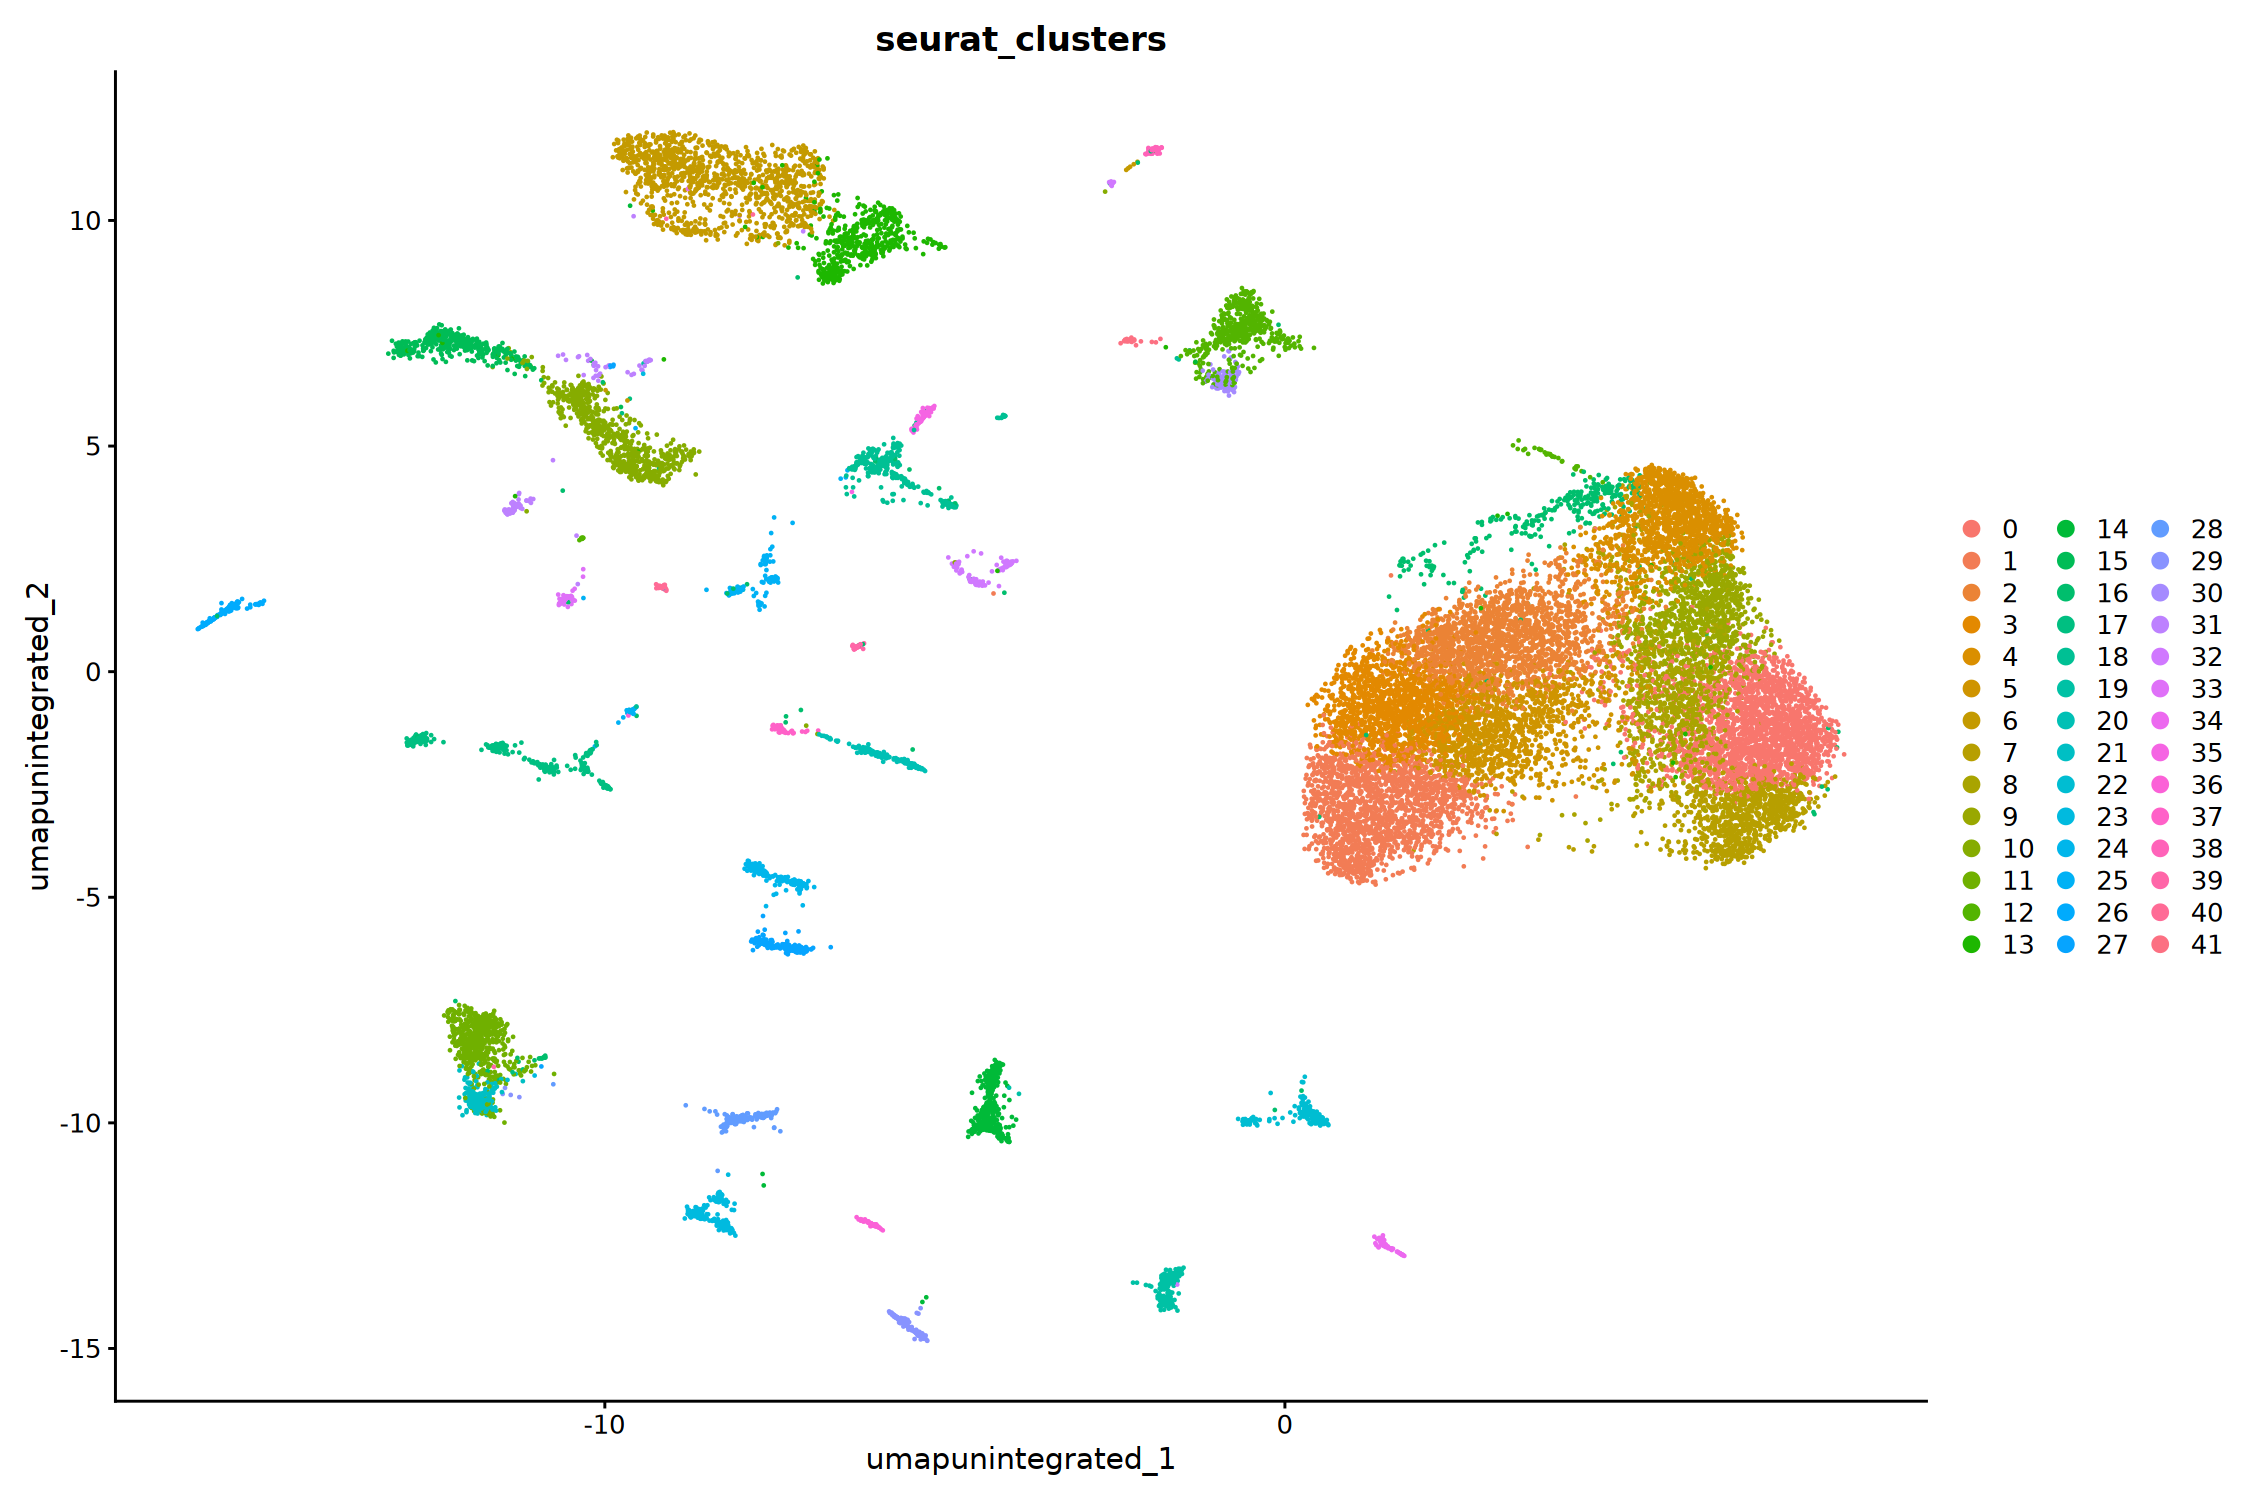

In [368]:
multiome_object_QCed <- RunUMAP(multiome_object_QCed, dims = 1:30, reduction = "pca", reduction.name = "umap.unintegrated")
DimPlot(multiome_object_QCed, reduction = "umap.unintegrated", group.by = c("stim", "seurat_clusters"))

In [369]:
multiome_object_QCed <- IntegrateLayers(object = multiome_object_QCed, method = CCAIntegration, orig.reduction = "pca", new.reduction = "integrated.cca",
    verbose = FALSE)

# re-join layers after integration
multiome_object_QCed[["RNA"]] <- JoinLayers(multiome_object_QCed[["RNA"]])

multiome_object_QCed <- FindNeighbors(multiome_object_QCed, reduction = "integrated.cca", dims = 1:30)
multiome_object_QCed <- FindClusters(multiome_object_QCed, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22034
Number of edges: 880872

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8595
Number of communities: 32
Elapsed time: 3 seconds


# Annotation of cells in the multiome object

We will be using GSE196235 to annotate & label cells with gex data. Please refer to https://cellxgene.cziscience.com/collections/348da6dc-5bf6-435d-adc5-37747b9ae38a

In [293]:
cell_type_annotations <- readRDS("7440585d-c11d-448b-a91b-3a379d241d87.rds")

In [246]:
cell_type_annotations

An object of class Seurat 
36379 features across 51645 samples within 1 assay 
Active assay: RNA (36379 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: UMAP

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



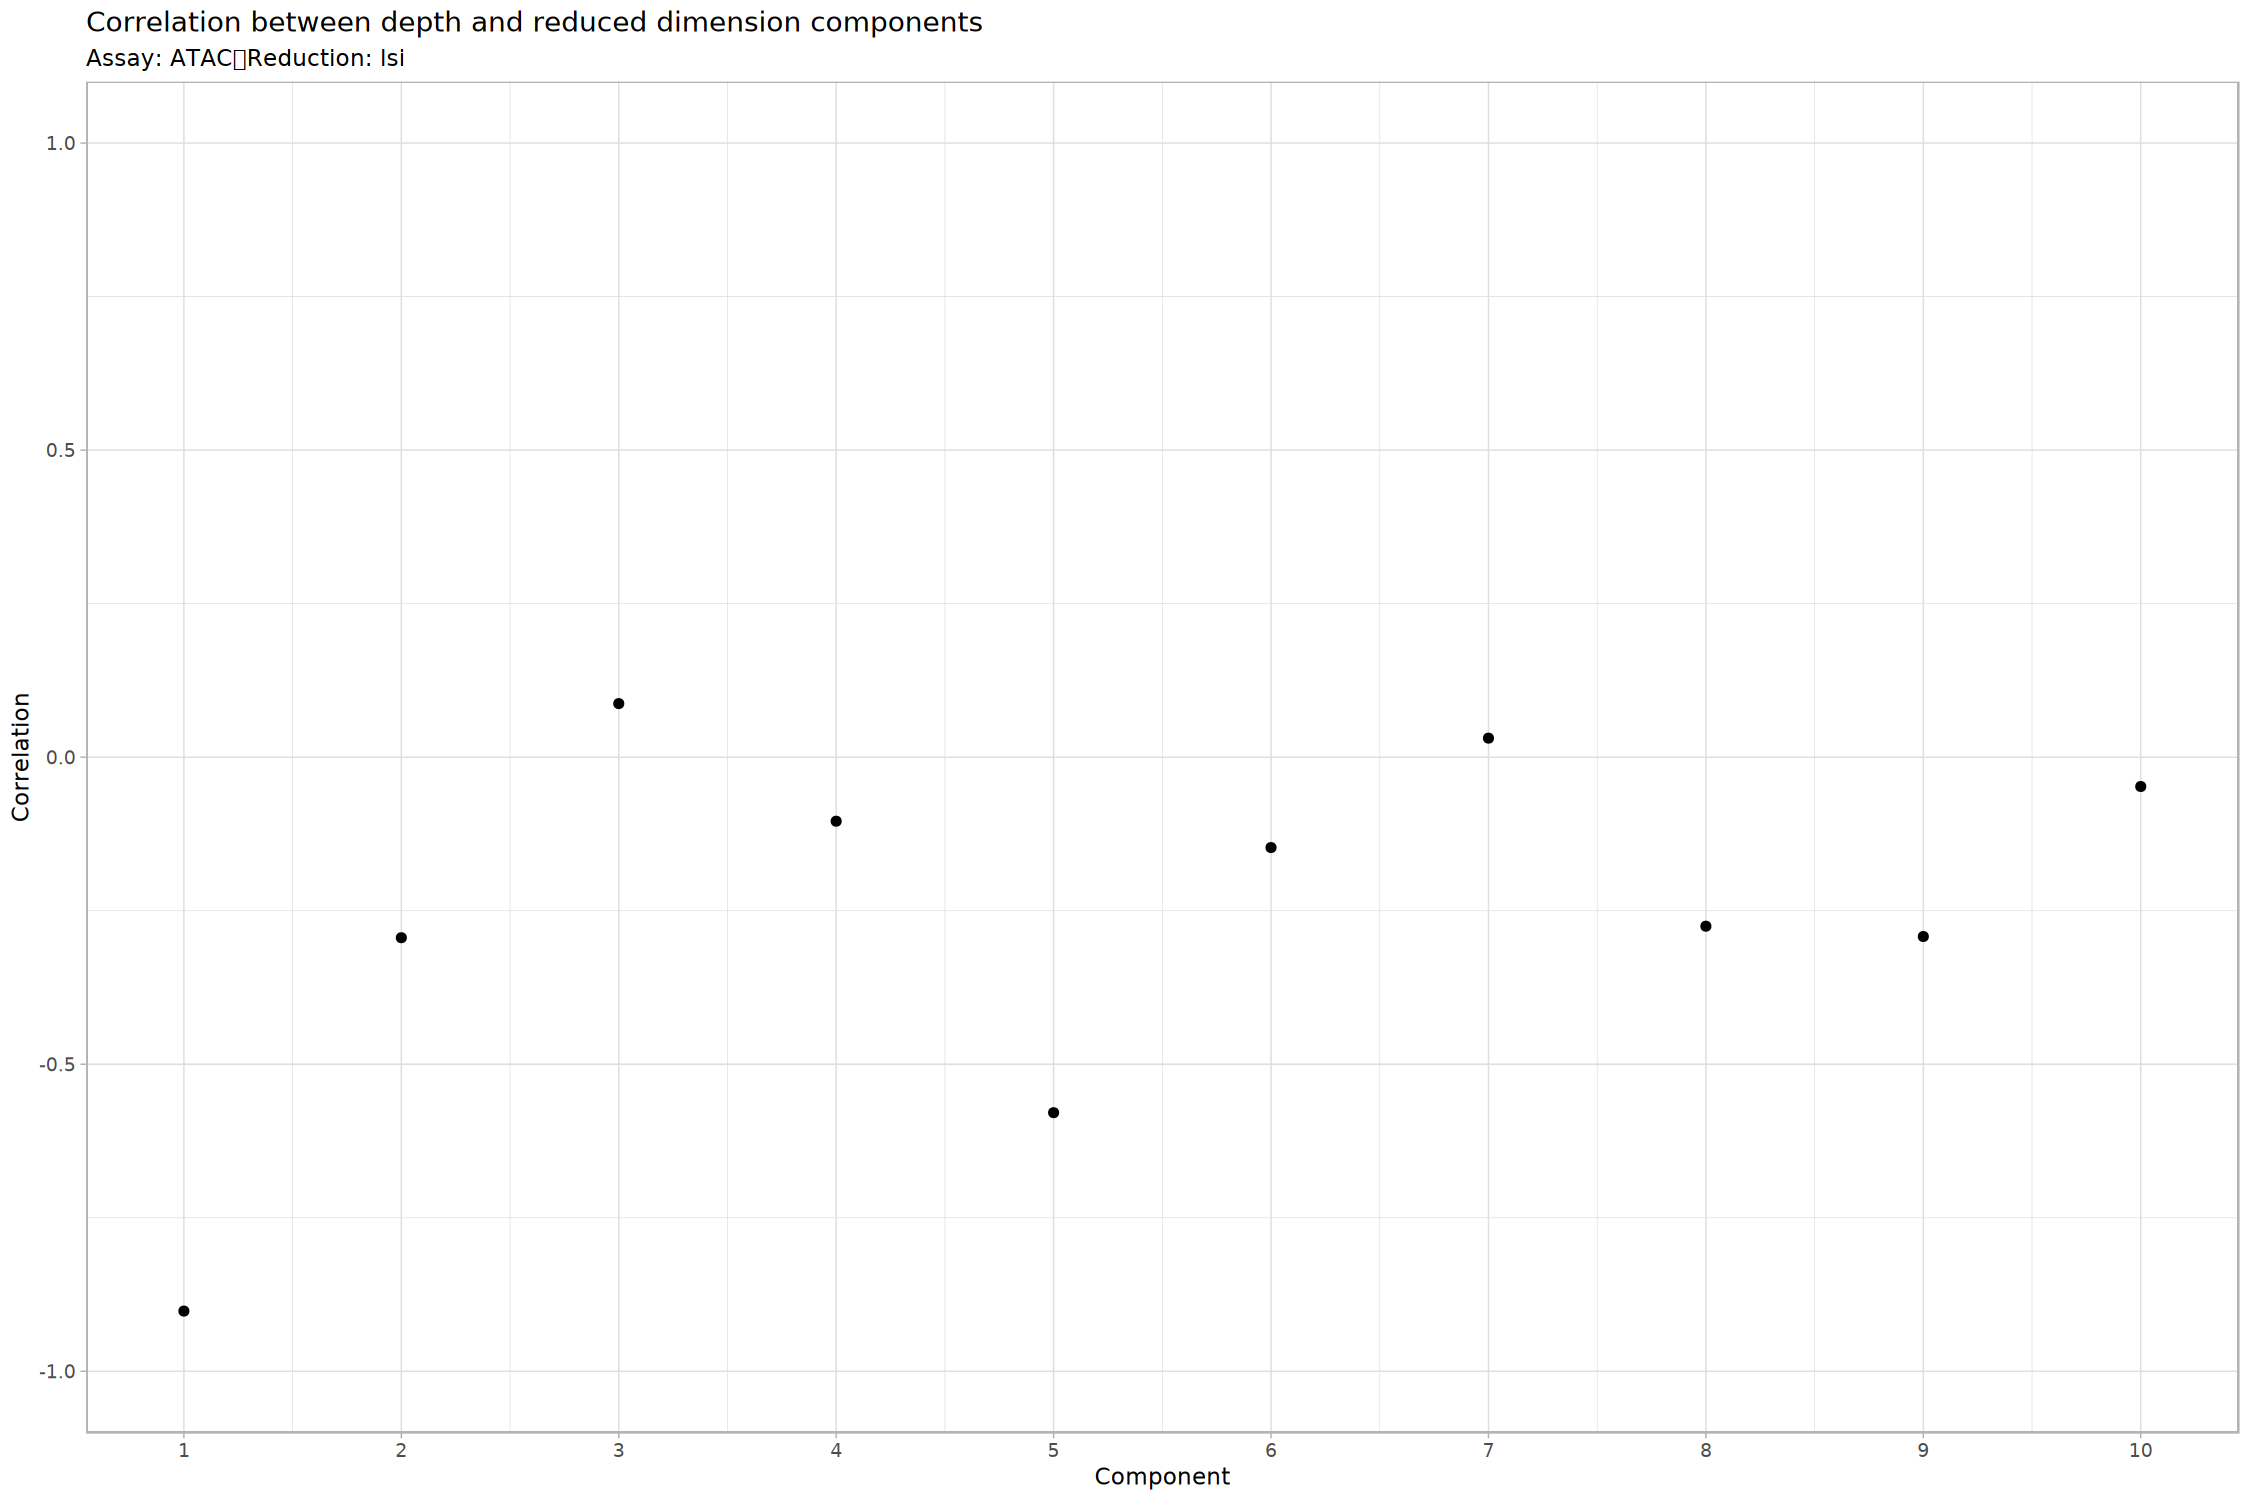

In [241]:
multiome_object_QCed <- RunTFIDF(multiome_object_QCed)
multiome_object_QCed <- FindTopFeatures(multiome_object_QCed, min.cutoff = 'q0')
multiome_object_QCed <- RunSVD(multiome_object_QCed)
DepthCor(multiome_object_QCed)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
12:18:12 UMAP embedding parameters a = 0.9922 b = 1.112

12:18:12 Read 22034 rows and found 29 numeric columns

12:18:12 Using Annoy for neighbor search, n_neighbors = 30

12:18:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:18:14 Writing NN index file to temp file /tmp/Rtmp9lus3I/filec61b065dce1b9

12:18:14 Searching Annoy index using 1 thread, search_k = 3000

12:18:19 Annoy recall = 100%

12:18:21 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

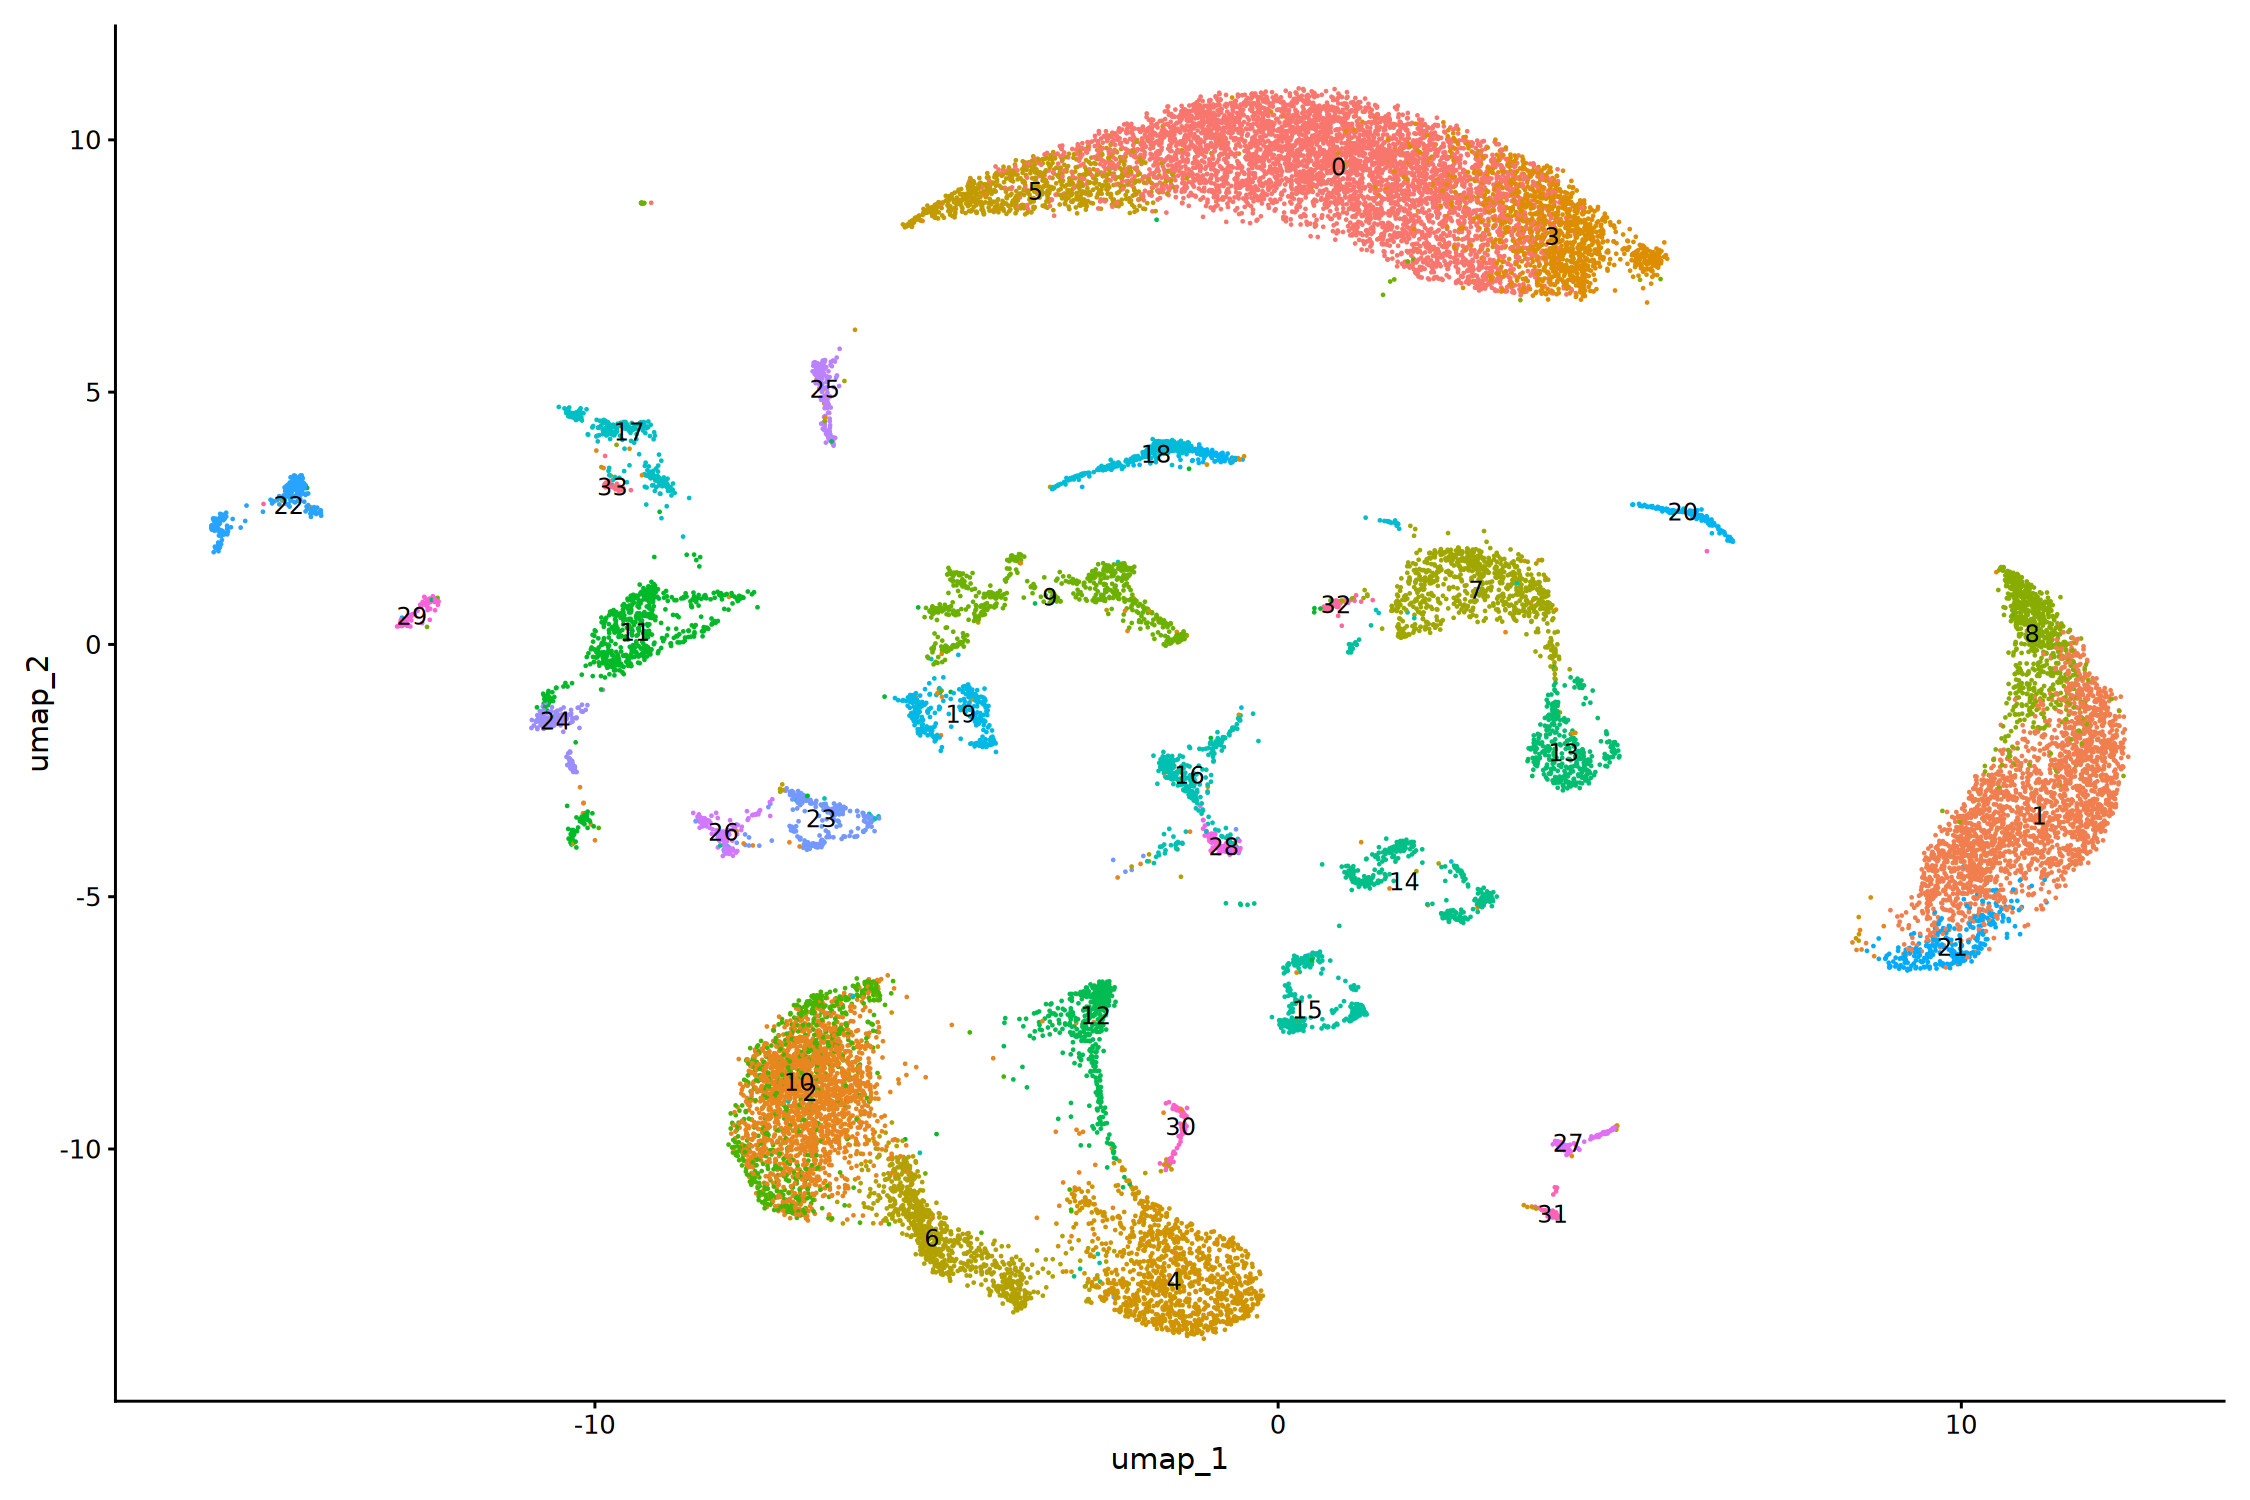

In [242]:
##cluster the cells
multiome_object_QCed <- RunUMAP(object = multiome_object_QCed, reduction = 'lsi', dims = 2:30)
multiome_object_QCed <- FindNeighbors(object = multiome_object_QCed, reduction = 'lsi', dims = 2:30)
multiome_object_QCed <- FindClusters(object = multiome_object_QCed, verbose = FALSE, algorithm = 3)
DimPlot(object = multiome_object_QCed, label = TRUE) + NoLegend()

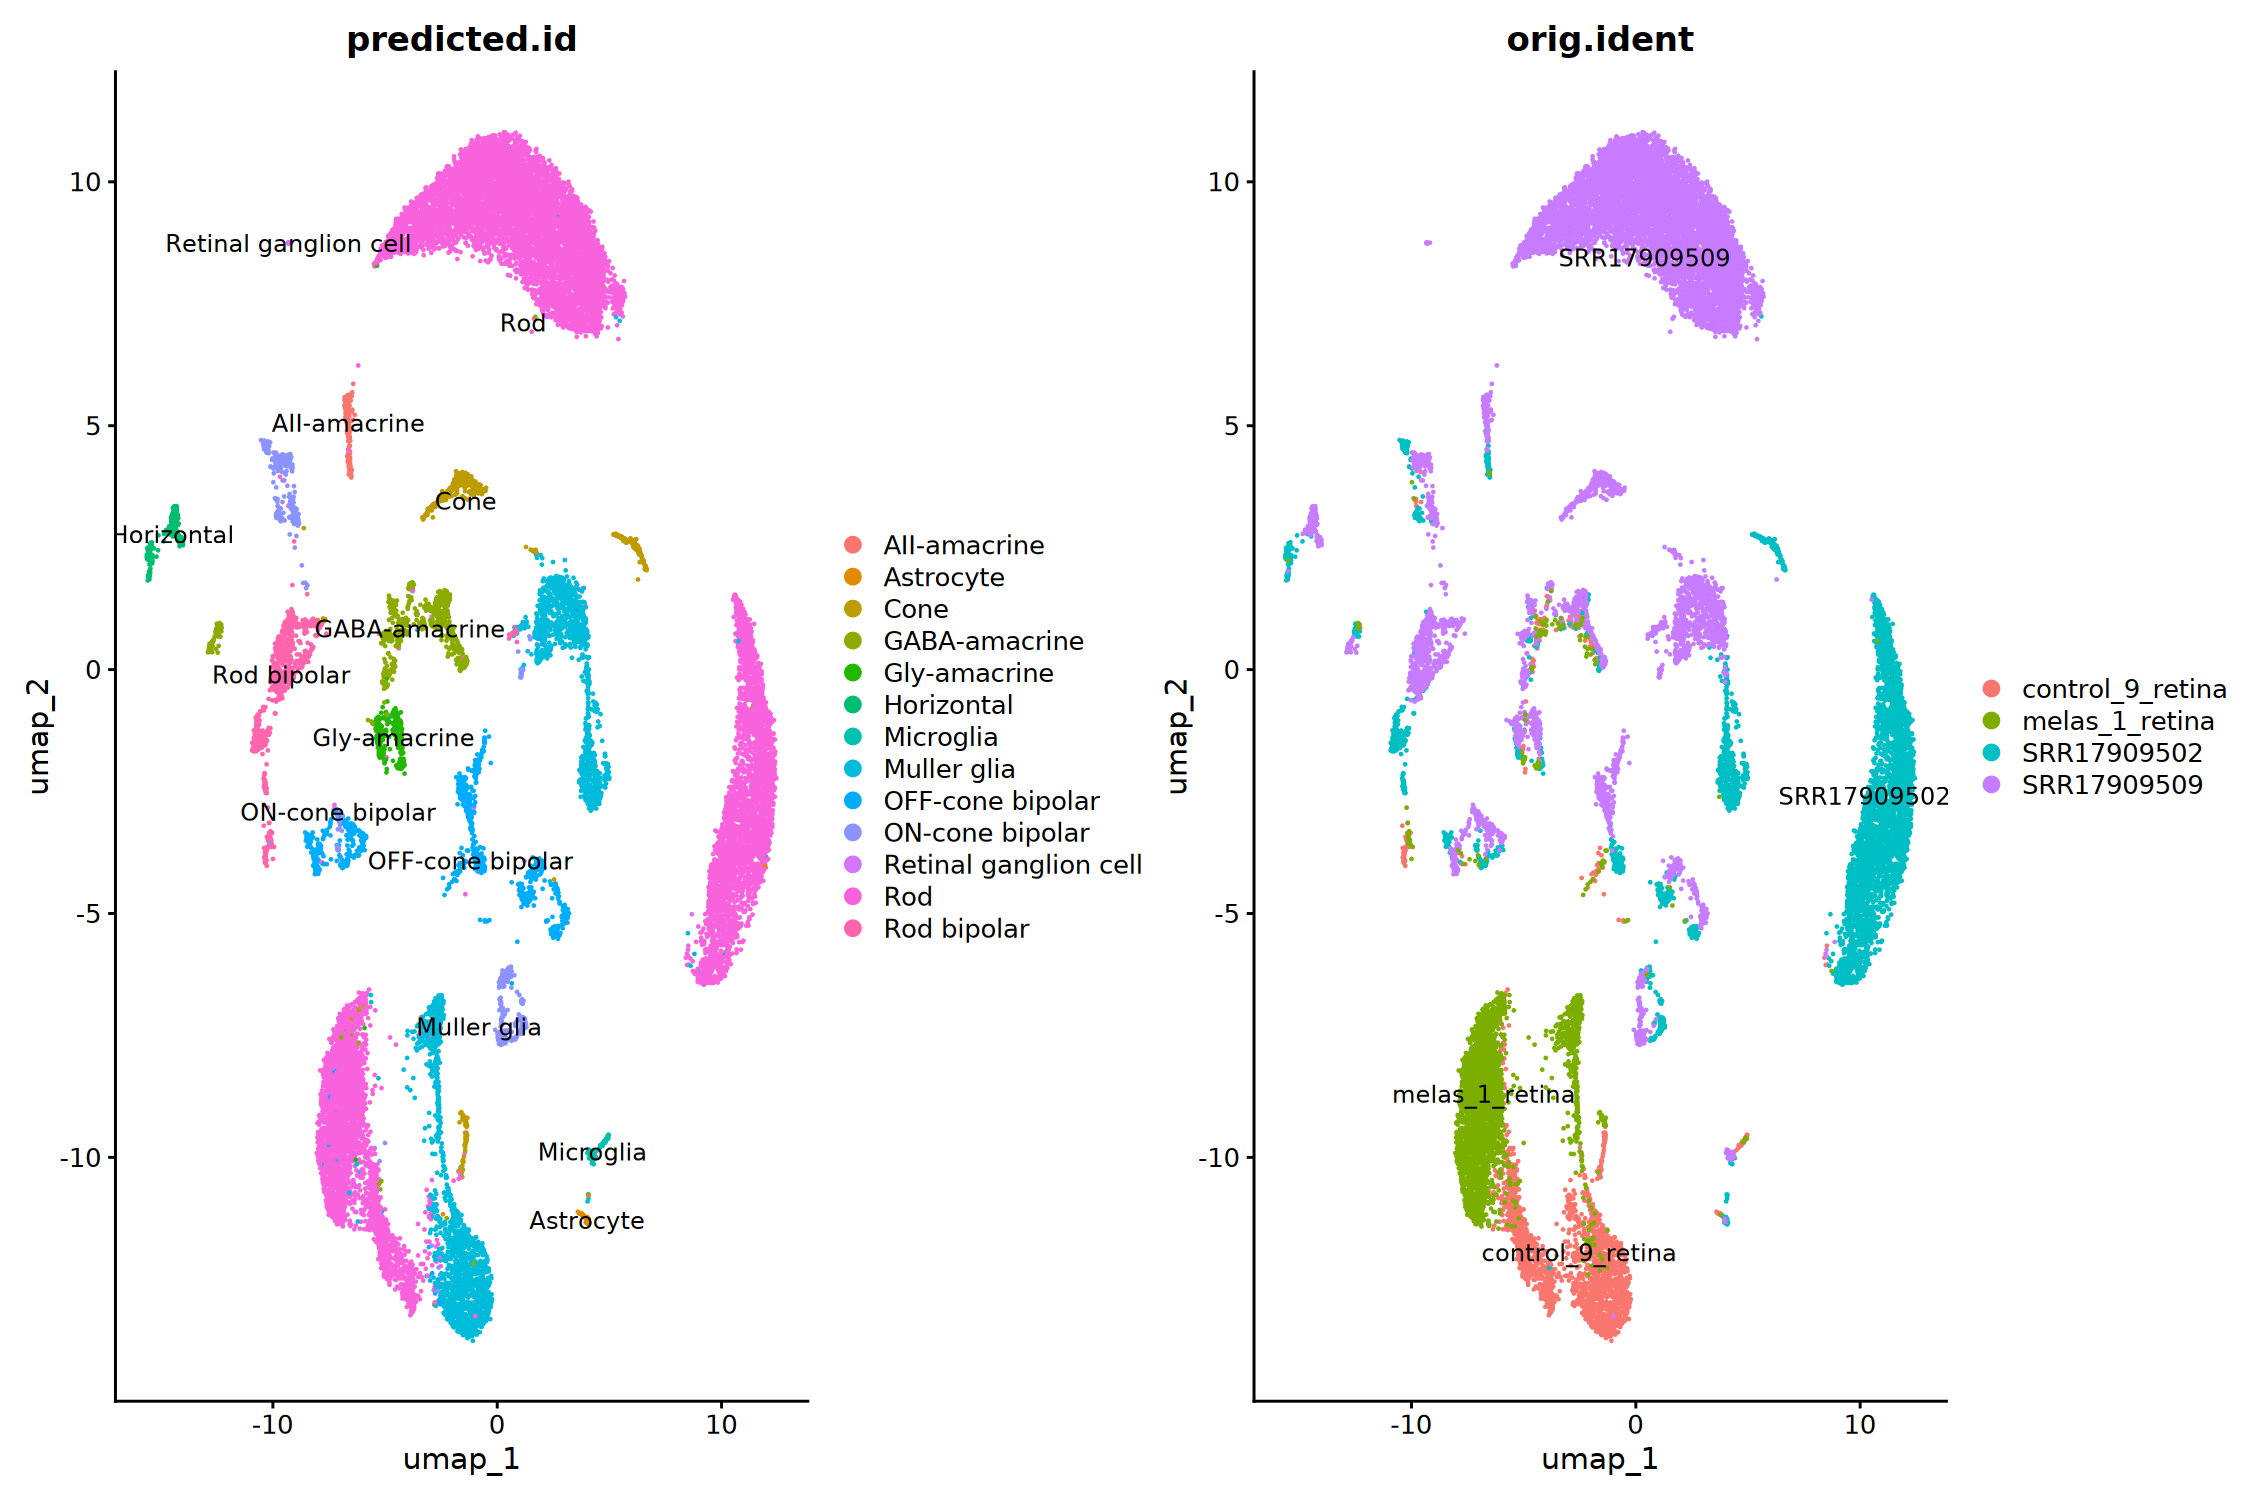

In [374]:
##need to do batch correction
DimPlot(object = multiome_object_QCed, label = TRUE, group.by =c("predicted.id","orig.ident")) 

In [239]:
multiome_object_QCed <- NormalizeData(
  object = multiome_object_QCed,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(multiome_object_QCed$nCount_RNA)
)

Normalizing layer: counts.control_9_retina

Normalizing layer: counts.SRR17909502

Normalizing layer: counts.SRR17909509

Normalizing layer: counts.melas_1_retina



In [247]:
multiome_object_QCed
cell_type_annotations

An object of class Seurat 
469704 features across 22034 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 8 layers present: counts.control_9_retina, counts.SRR17909502, counts.SRR17909509, counts.melas_1_retina, data.control_9_retina, data.SRR17909502, data.SRR17909509, data.melas_1_retina
 1 other assay present: ATAC
 2 dimensional reductions calculated: lsi, umap

In [244]:
DefaultAssay(multiome_object_QCed) <- "RNA"

In [252]:
multiome_object_QCed@assays$RNA

MIR1302-2HG
FAM138A    
OR4F5      
AL627309.1 
AL627309.3 
AL627309.2 
AL627309.5 
AL627309.4 
AP006222.2 
AL732372.1

In [295]:
## Need to change rownames so Seurat detects the features
cell_type_annotations[["RNA"]] <- as(object = cell_type_annotations[["RNA"]], Class = "Assay5")
new_rownames <-cell_type_annotations@assays$RNA[[2]]$feature_name %>% as.vector()
rownames(cell_type_annotations@assays$RNA) <- new_rownames

Warning message:
"Assay RNA changing from Assay to Assay5"


In [347]:
transfer.anchors <- FindTransferAnchors(
    reference = cell_type_annotations,
    query = multiome_object_QCed,
    reference.assay = 'RNA',
    query.assay = 'RNA',
    reduction = 'cca',
    features = rownames(multiome_object_QCed@assays$RNA)
)

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4814 anchors

Finding neighborhoods

Finding anchors

	Found 14296 anchors

Finding neighborhoods

Finding anchors

	Found 31119 anchors

Finding neighborhoods

Finding anchors

	Found 6471 anchors



In [349]:
predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = cell_type_annotations$cell_type__custom,
  weight.reduction = multiome_object_QCed[['lsi']],
  dims = 2:30
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [350]:
multiome_object_QCed <- AddMetaData(object = multiome_object_QCed, metadata = predicted.labels)

**need to do batch correction**

In [382]:
multiome_object_QCed$orig.ident %>% unique()

[1] "control_9_retina" "SRR17909502"      "SRR17909509"      "melas_1_retina"

In [385]:
multiome_object_QCed_test <- subset(multiome_object, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 5)

In [388]:
DefaultAssay(multiome_object_QCed_test) <- "ATAC"

In [389]:
multiome_object_QCed_test <- FindTopFeatures(multiome_object_QCed_test, min.cutoff = 10)
multiome_object_QCed_test <- RunTFIDF(multiome_object_QCed_test)
multiome_object_QCed_test <- RunSVD(multiome_object_QCed_test)
multiome_object_QCed_test <- RunUMAP(multiome_object_QCed_test, reduction = "lsi", dims = 2:30)
p1 <- DimPlot(multiome_object_QCed_test, group.by = "orig.ident")

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

22:44:26 UMAP embedding parameters a = 0.9922 b = 1.112

22:44:26 Read 22034 rows and found 29 numeric columns

22:44:26 Using Annoy for neighbor search, n_neighbors = 30

22:44:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:44:28 Writing NN index file to temp file /tmp/Rtmp9lus3I/filec61b04a540b29

22:44:28 Searching Annoy index using 1 thread, search_k = 3000

22:44:33 Annoy recall = 100%

22:44:35 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

22:44:38 Initializing from normalized Laplacian + noise (using RSpectra)



In [391]:
multiome_object_QCed_test

An object of class Seurat 
469704 features across 22034 samples within 2 assays 
Active assay: ATAC (433103 features, 419852 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

# Batch correction & How to integrate ATAC assays

Please refer to https://stuartlab.org/signac/articles/integrate_atac

In [399]:
SRR17909502 <- FindTopFeatures(SRR17909502, min.cutoff = 10)
SRR17909502 <- RunTFIDF(SRR17909502)
SRR17909502 <- RunSVD(SRR17909502)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



In [400]:
SRR17909509 <- FindTopFeatures(SRR17909509, min.cutoff = 10)
SRR17909509 <- RunTFIDF(SRR17909509)
SRR17909509 <- RunSVD(SRR17909509)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



In [401]:
SRR17909509$dataset <- "SRR17909509"
SRR17909502$dataset <- "SRR17909502"

In [402]:
pbmc.combined <- merge(SRR17909509, SRR17909502)

Warning message:
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


In [406]:
DefaultAssay(pbmc.combined) <- "ATAC"

In [407]:
# process the combined dataset
pbmc.combined <- FindTopFeatures(pbmc.combined, min.cutoff = 10)
pbmc.combined <- RunTFIDF(pbmc.combined)
pbmc.combined <- RunSVD(pbmc.combined)
pbmc.combined <- RunUMAP(pbmc.combined, reduction = "lsi", dims = 2:30)
p1 <- DimPlot(pbmc.combined, group.by = "dataset")

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

22:58:05 UMAP embedding parameters a = 0.9922 b = 1.112

22:58:05 Read 17131 rows and found 29 numeric columns

22:58:05 Using Annoy for neighbor search, n_neighbors = 30

22:58:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:58:06 Writing NN index file to temp file /tmp/Rtmp9lus3I/filec61b04175889d

22:58:06 Searching Annoy index using 1 thread, search_k = 3000

22:58:10 Annoy recall = 100%

22:58:13 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

22:58:15 Initializing from normalized Laplacian + noise (using RSpectra)



ERROR: Error in eval(expr, envir, enclos): object 'P1' not found


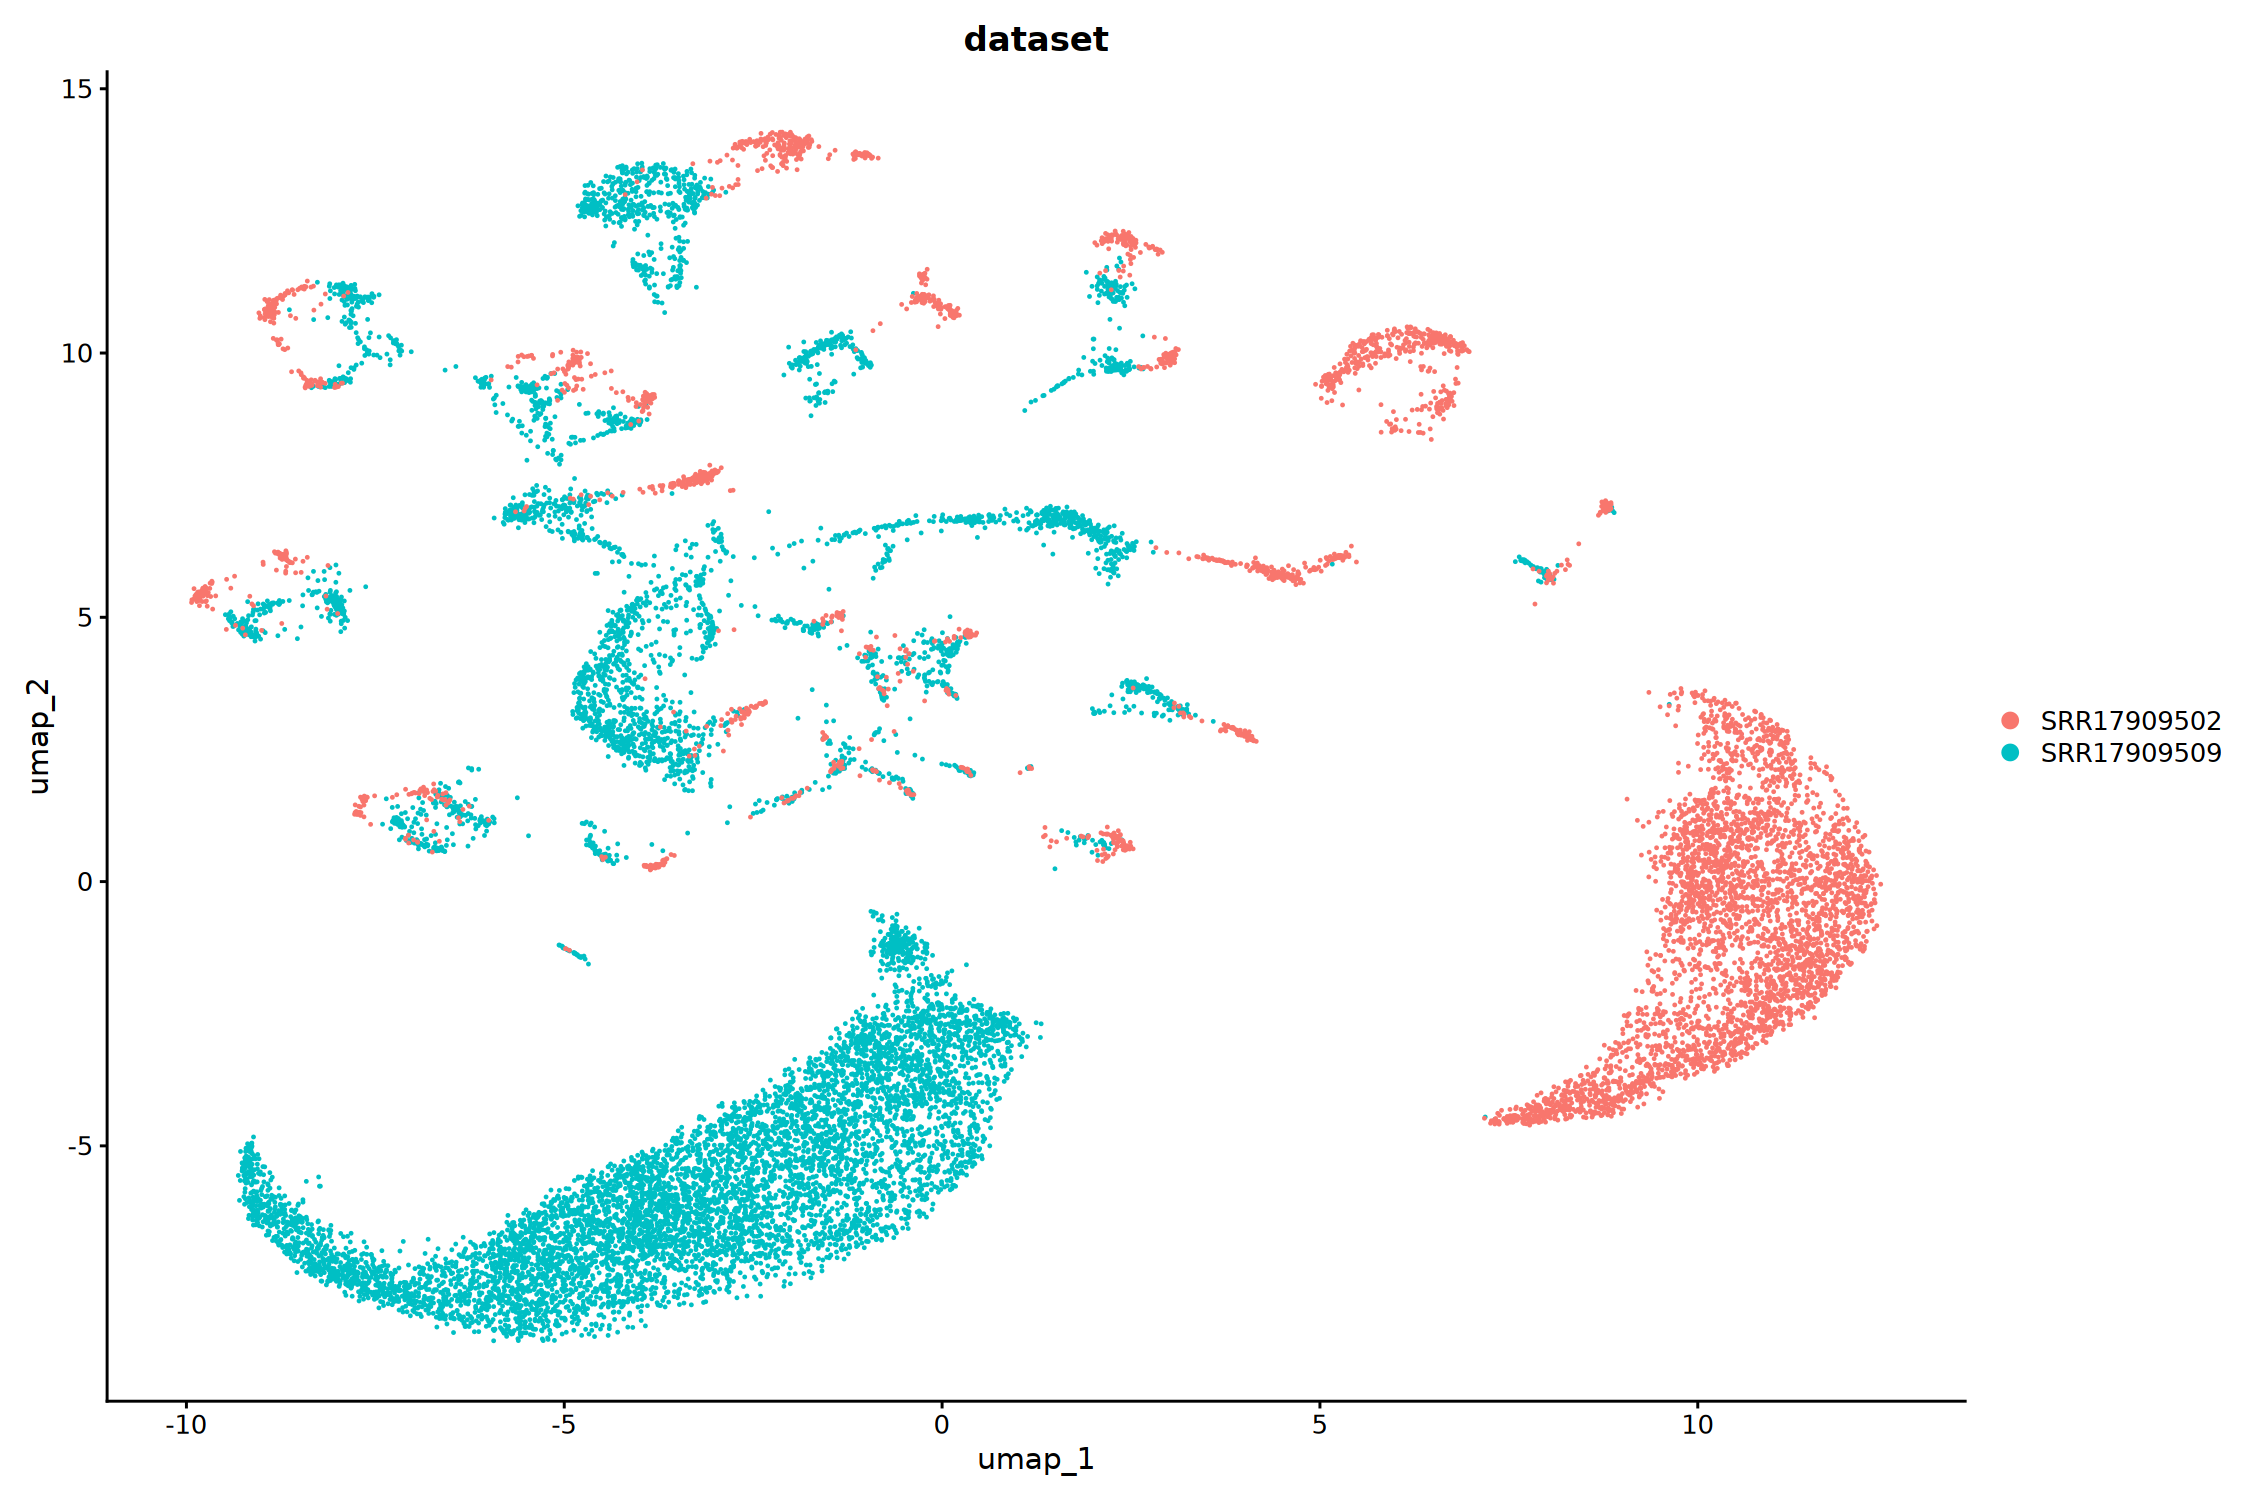

In [409]:
p1

In [408]:
ls()

[1] "annotation"                "atac_counts"              
 [3] "atac_merger"               "atac_object"              
 [5] "atac_prefixes"             "cell_type_annotations"    
 [7] "commonpeakset_atlas"       "CommonPeakSetter"         
 [9] "control_9_retina"          "counts"                   
[11] "fragments"                 "fragpath"                 
[13] "GSE196235"                 "GSE196235_prefixes"       
[15] "melas_1_retina"            "MergePeaks_better"        
[17] "metadata"                  "multiome_merger"          
[19] "multiome_object"           "multiome_object_QCed"     
[21] "multiome_object_QCed_test" "multiome_prefixes"        
[23] "new_rownames"              "p1"                       
[25] "pbmc.combined"             "plot1"                    
[27] "plot2"                     "predicted.labels"         
[29] "retina_atlas"              "rna_counts"               
[31] "run_multiome_script"       "sample_prefixes"          
[33] "SRR13633765"               "SRR13633773"              
[35] "SRR17909502"               "SRR17909509"              
[37] "SRR23990991"               "SRR23990998"              
[39] "transfer.anchors"

In [411]:
# find integration anchors
integration.anchors <- FindIntegrationAnchors(
  object.list = list(SRR17909509, SRR17909502),
  anchor.features = rownames(pbmc.multi),
  reduction = "rlsi",
  dims = 2:30
)

# integrate LSI embeddings
integrated <- IntegrateEmbeddings(
  anchorset = integration.anchors,
  reductions = pbmc.combined[["lsi"]],
  new.reduction.name = "integrated_lsi",
  dims.to.integrate = 1:30
)

# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:30)
p2 <- DimPlot(integrated, group.by = "dataset")

Warning message in CheckDuplicateCellNames(object.list = object.list):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."
Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 2476 anchors

Warning message:
"Layer counts isn't present in the assay object; returning NULL"
Warning message:
"Layer counts isn't present in the assay object; returning NULL"
Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Layer counts isn't present in the assay object; returning NULL"
23:01:15 UMAP embedding parameters a = 0.9922 b = 1.112

23:01:15 Read 17131 rows and found 29 numeric columns

23:01:15 Using Annoy for neighbor search, n_neighbors = 30

23:01:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10  

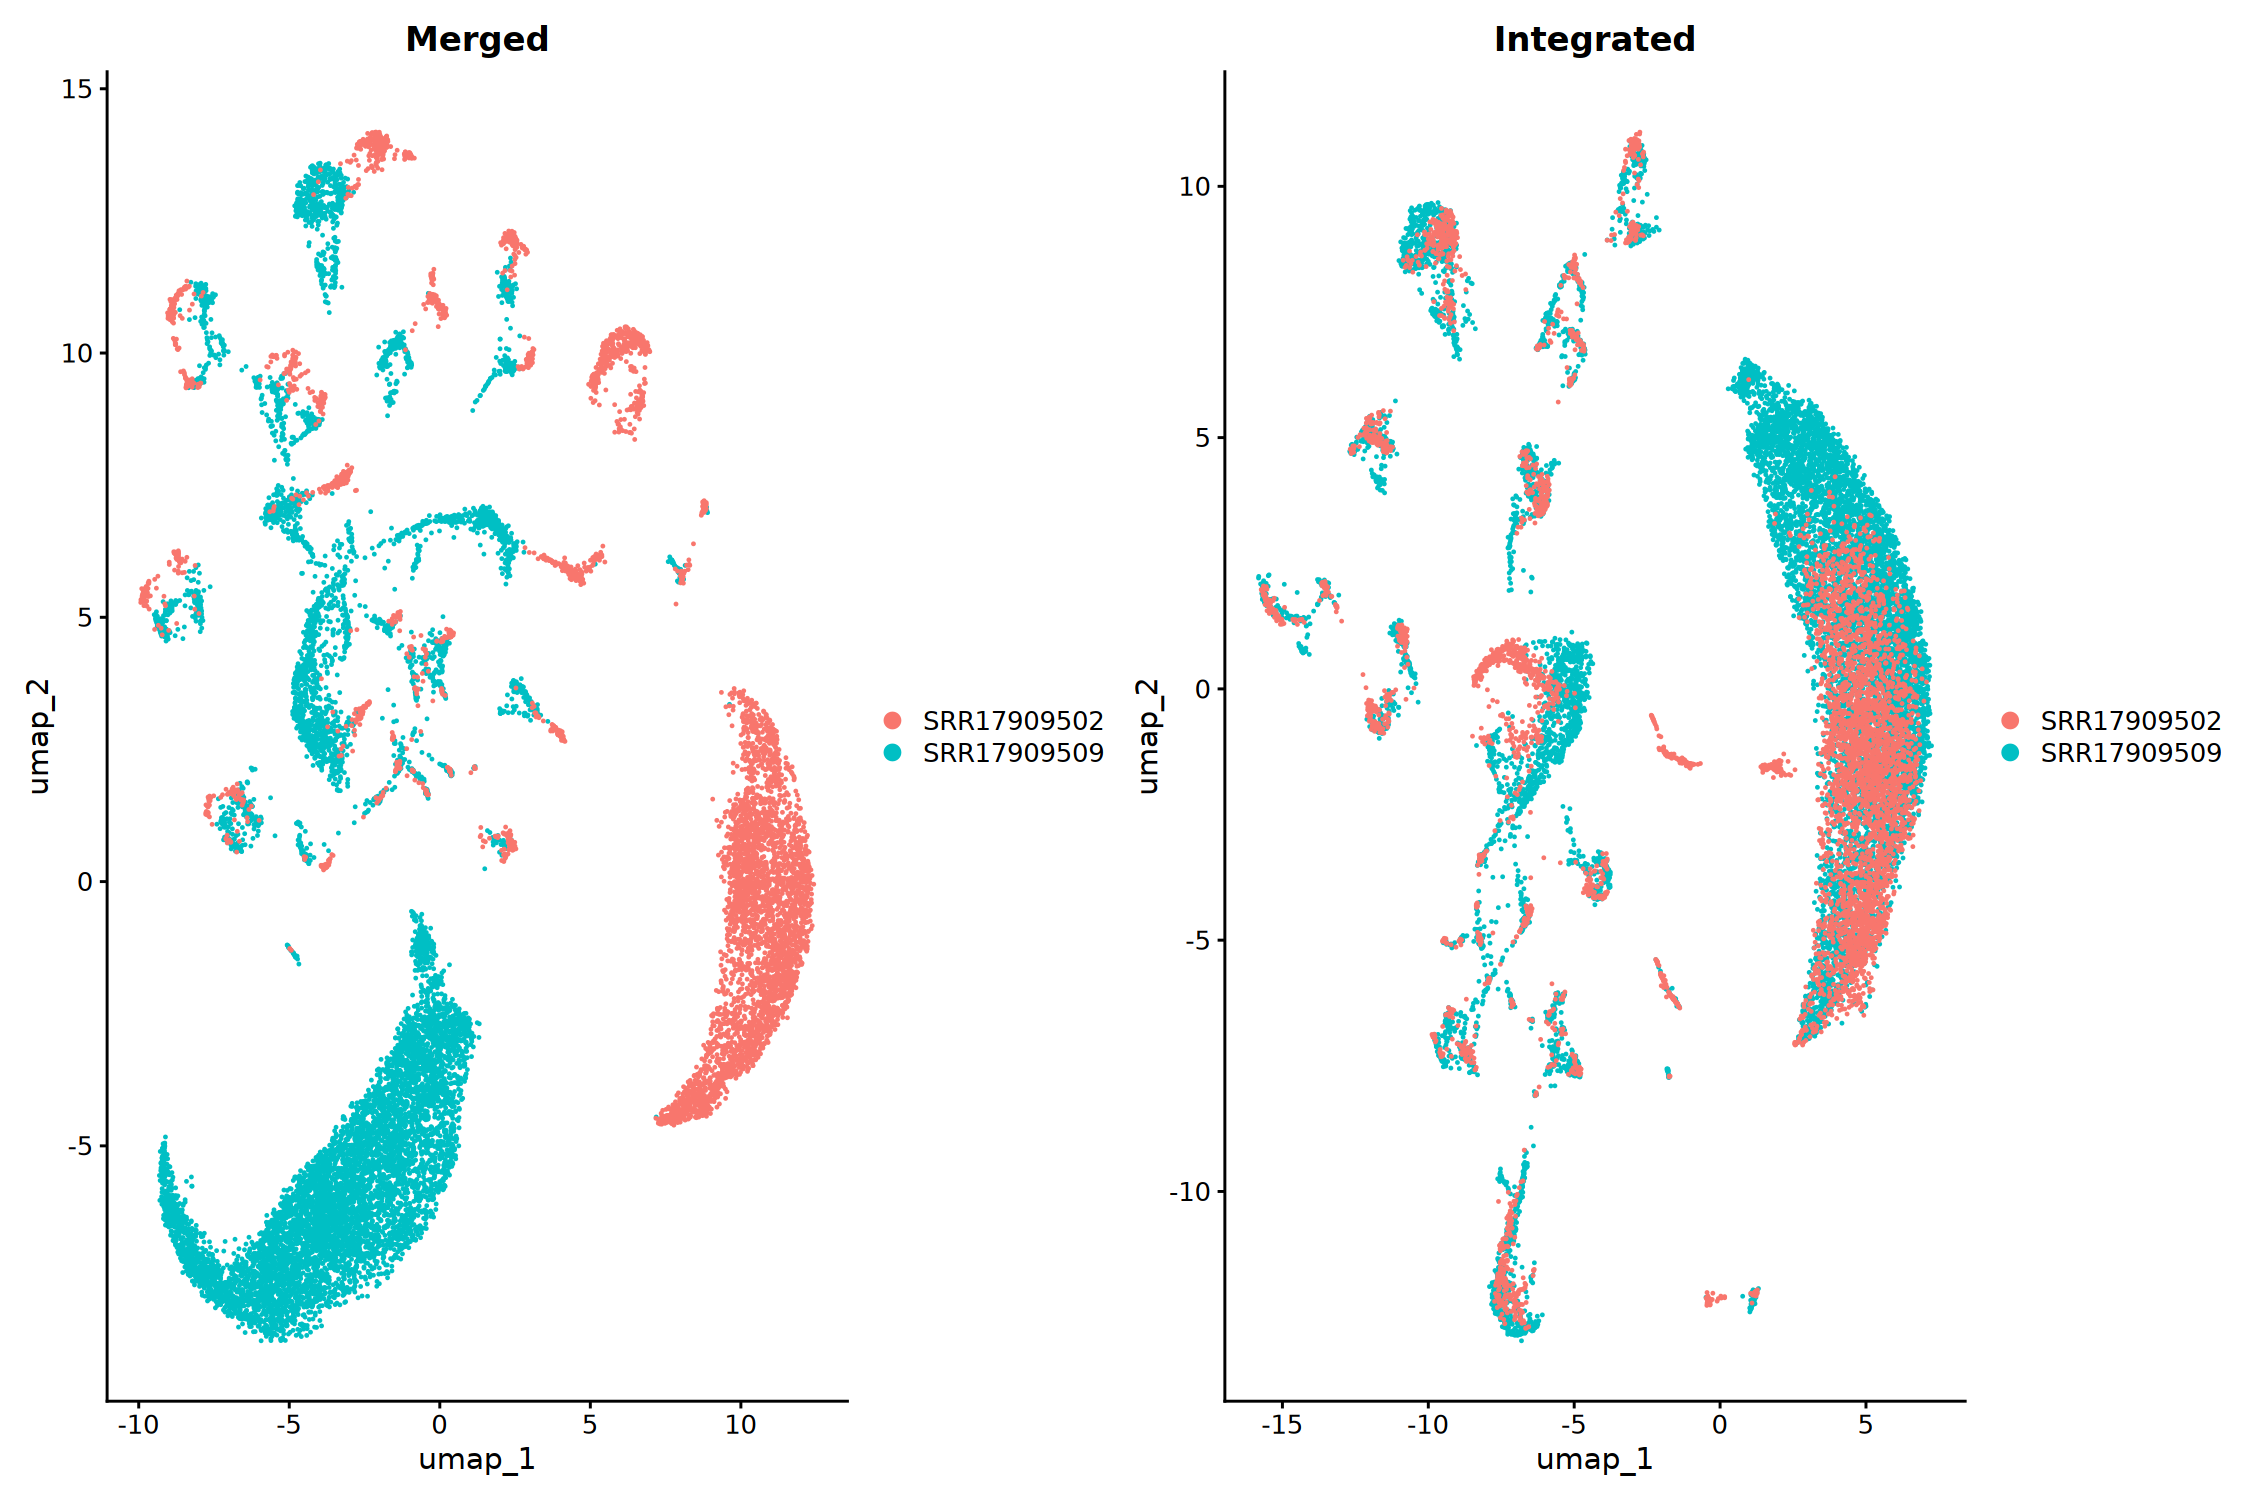

In [413]:
(p1 + ggtitle("Merged")) | (p2 + ggtitle("Integrated"))

In [397]:
## need to reprocess each multiome sample such that the LSI is calculated for each sample
integration.anchors <- FindIntegrationAnchors(
  anchor.features = rownames(multiome_object_QCed),
  reduction = "rlsi"
)

Computing within dataset neighborhoods



ERROR: Error in object.list[[x]]: subscript out of bounds
